In [1]:
import tensorflow as tf
import scipy.io.wavfile as wav
import numpy as np
import os
import time
from tqdm import tqdm

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
class PlanarVAE(tf.keras.Model):
    """Planar Variational Autoencoder."""

    def __init__(self, latent_dim, input_shape_):
        super(PlanarVAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_shape_ = input_shape_

        # Encoder
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape_),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(latent_dim + latent_dim)  # mean and log variance
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(np.prod(input_shape_), activation=None),
            tf.keras.layers.Reshape(target_shape=input_shape_)
        ])

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        logits = self.decode(z)
        return logits

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        batch_size = tf.shape(mean)[0]
        eps = tf.random.normal(shape=(batch_size, self.latent_dim))
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        logits = self.decoder(z)
        return logits

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps)

In [16]:
import numpy as np
import sounddevice as sd

def play_npy_audio(file_path, sample_rate=44100):
    # Load the .npy file with allow_pickle=True
    example = np.load(file_path, allow_pickle=True).tolist()

    # Extract the time series data
    audio_data = np.array(example["time_series"], dtype=np.float32)

    # Play the audio
    sd.play(audio_data, sample_rate)
    sd.wait()  # Wait until the audio is finished playing

# Example usage:
play_npy_audio('cleaned_data/139.npy')

In [5]:
subsample_factor = 4
def parse_tfrecord_fn(tf_example):
    feature_description = {
        "song_id": tf.io.FixedLenFeature([], tf.int64),
        "genre_id": tf.io.FixedLenFeature([], tf.int64),
        "time_series": tf.io.VarLenFeature(tf.float32)
    }
    example = tf.io.parse_single_example(tf_example, feature_description)
    example["time_series"] = tf.sparse.to_dense(example["time_series"])
    return example

def create_tf_example_from_chunk(song_id, genre_id, chunk):
    feature = {
        "song_id": tf.train.Feature(int64_list=tf.train.Int64List(value=[song_id])),
        "genre_id": tf.train.Feature(int64_list=tf.train.Int64List(value=[genre_id])),
        "time_series": tf.train.Feature(float_list=tf.train.FloatList(value=chunk))
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def preprocess_tfrecords(input_folder, output_folder, subsample_factor=1, chunk_duration=5, sampling_rate=44100):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    chunk_size = (sampling_rate//subsample_factor) * chunk_duration

    tf_record_files = [os.path.join(input_folder, file) for file in os.listdir(input_folder) if file.endswith('.tfrecord')]
    raw_dataset = tf.data.TFRecordDataset(tf_record_files).map(parse_tfrecord_fn)

    chunk_id = 0
    total_files = len(tf_record_files)
    for file_index, example in tqdm(enumerate(raw_dataset), total=total_files, desc="Processing files"):
        song_id = example["song_id"].numpy()
        genre_id = example["genre_id"].numpy()
        time_series = example["time_series"].numpy()

        # Subsample if necessary
        subsampled_time_series = time_series[::subsample_factor]

        # Cut the time series into chunks
        num_chunks = len(subsampled_time_series) // chunk_size
        for i in tqdm(range(num_chunks), desc=f"Creating chunks for file {file_index + 1}", leave=False):
            chunk = subsampled_time_series[i * chunk_size : (i + 1) * chunk_size]
            tf_example = create_tf_example_from_chunk(song_id, genre_id, chunk)

            # Write the chunk to a new TFRecord file
            output_file = os.path.join(output_folder, f'chunk_{chunk_id}.tfrecord')
            with tf.io.TFRecordWriter(output_file) as writer:
                writer.write(tf_example.SerializeToString())

            chunk_id += 1

        tqdm.write(f'Processed file {file_index + 1}/{total_files}, generated {num_chunks} chunks.')

    print(f'Total chunks created: {chunk_id}')

In [6]:
preprocess_tfrecords('drive/MyDrive/tf_data', 'drive/MyDrive/tf_data_chunks', subsample_factor=subsample_factor)

Processing files:   7%|▋         | 1/14 [00:00<00:04,  3.25it/s]

Processed file 1/14, generated 5 chunks.



Processing files:  14%|█▍        | 2/14 [00:00<00:03,  3.88it/s]

Processed file 2/14, generated 5 chunks.



Processing files:  21%|██▏       | 3/14 [00:00<00:02,  4.22it/s]

Processed file 3/14, generated 5 chunks.



Processing files:  29%|██▊       | 4/14 [00:00<00:02,  4.43it/s]

Processed file 4/14, generated 5 chunks.



Processing files:  36%|███▌      | 5/14 [00:01<00:02,  4.44it/s]

Processed file 5/14, generated 5 chunks.



Processing files:  43%|████▎     | 6/14 [00:01<00:01,  4.53it/s]

Processed file 6/14, generated 5 chunks.



Processing files:  50%|█████     | 7/14 [00:01<00:01,  4.58it/s]

Processed file 7/14, generated 5 chunks.



Processing files:  57%|█████▋    | 8/14 [00:01<00:01,  4.59it/s]

Processed file 8/14, generated 5 chunks.



Processing files:  64%|██████▍   | 9/14 [00:02<00:01,  4.47it/s]

Processed file 9/14, generated 5 chunks.



Processing files:  71%|███████▏  | 10/14 [00:02<00:00,  4.67it/s]

Processed file 10/14, generated 5 chunks.



Processing files:  79%|███████▊  | 11/14 [00:02<00:00,  4.68it/s]

Processed file 11/14, generated 5 chunks.



Processing files:  86%|████████▌ | 12/14 [00:02<00:00,  4.96it/s]

Processed file 12/14, generated 5 chunks.



Processing files:  93%|█████████▎| 13/14 [00:02<00:00,  5.08it/s]

Processed file 13/14, generated 5 chunks.



Processing files: 100%|██████████| 14/14 [00:02<00:00,  5.54it/s]

Processed file 14/14, generated 5 chunks.



Creating chunks for file 15: 100%|██████████| 5/5 [00:00<00:00, 43.75it/s]
Processing files: 15it [00:03,  5.91it/s]                        

Processed file 15/14, generated 5 chunks.



Creating chunks for file 16: 100%|██████████| 5/5 [00:00<00:00, 45.38it/s]
Processing files: 16it [00:03,  6.32it/s]

Processed file 16/14, generated 5 chunks.



Creating chunks for file 17:  80%|████████  | 4/5 [00:00<00:00, 38.28it/s]
Processing files: 17it [00:03,  6.39it/s]

Processed file 17/14, generated 5 chunks.



Creating chunks for file 18:  80%|████████  | 4/5 [00:00<00:00, 35.06it/s]
Processing files: 18it [00:03,  6.31it/s]

Processed file 18/14, generated 5 chunks.



Creating chunks for file 19: 100%|██████████| 5/5 [00:00<00:00, 43.70it/s]
Processing files: 19it [00:03,  6.47it/s]

Processed file 19/14, generated 5 chunks.



Creating chunks for file 20:  60%|██████    | 3/5 [00:00<00:00, 29.52it/s]
Processing files: 20it [00:03,  6.05it/s]

Processed file 20/14, generated 5 chunks.



Creating chunks for file 21:  80%|████████  | 4/5 [00:00<00:00, 39.19it/s]
Processing files: 21it [00:04,  6.24it/s]

Processed file 21/14, generated 5 chunks.



Creating chunks for file 22: 100%|██████████| 5/5 [00:00<00:00, 48.85it/s]
Processing files: 22it [00:04,  6.44it/s]

Processed file 22/14, generated 5 chunks.



Creating chunks for file 23:  80%|████████  | 4/5 [00:00<00:00, 39.86it/s]
Processing files: 23it [00:04,  6.58it/s]

Processed file 23/14, generated 5 chunks.



Creating chunks for file 24:   0%|          | 0/5 [00:00<?, ?it/s]
Processing files: 24it [00:04,  6.92it/s]

Processed file 24/14, generated 5 chunks.



Creating chunks for file 25:  80%|████████  | 4/5 [00:00<00:00, 37.74it/s]
Processing files: 25it [00:04,  6.77it/s]

Processed file 25/14, generated 5 chunks.



Creating chunks for file 26:  80%|████████  | 4/5 [00:00<00:00, 37.84it/s]
Processing files: 26it [00:04,  6.55it/s]

Processed file 26/14, generated 5 chunks.



Creating chunks for file 27:  80%|████████  | 4/5 [00:00<00:00, 37.92it/s]
Processing files: 27it [00:04,  6.19it/s]

Processed file 27/14, generated 5 chunks.



Creating chunks for file 28:   0%|          | 0/5 [00:00<?, ?it/s]
Processing files: 28it [00:05,  6.60it/s]

Processed file 28/14, generated 5 chunks.



Creating chunks for file 29: 100%|██████████| 5/5 [00:00<00:00, 45.32it/s]
Processing files: 29it [00:05,  6.81it/s]

Processed file 29/14, generated 5 chunks.



Creating chunks for file 30: 100%|██████████| 5/5 [00:00<00:00, 35.29it/s]
Processing files: 30it [00:05,  6.49it/s]

Processed file 30/14, generated 5 chunks.



Creating chunks for file 31: 100%|██████████| 5/5 [00:00<00:00, 44.79it/s]
Processing files: 31it [00:05,  6.78it/s]

Processed file 31/14, generated 5 chunks.



Creating chunks for file 32: 100%|██████████| 5/5 [00:00<00:00, 44.81it/s]
Processing files: 32it [00:05,  6.65it/s]

Processed file 32/14, generated 5 chunks.



Creating chunks for file 33:  80%|████████  | 4/5 [00:00<00:00, 38.04it/s]
Processing files: 33it [00:05,  6.51it/s]

Processed file 33/14, generated 5 chunks.



Creating chunks for file 34:  80%|████████  | 4/5 [00:00<00:00, 35.25it/s]
Processing files: 34it [00:06,  6.25it/s]

Processed file 34/14, generated 5 chunks.



Creating chunks for file 35:  80%|████████  | 4/5 [00:00<00:00, 37.63it/s]
Processing files: 35it [00:06,  6.14it/s]

Processed file 35/14, generated 5 chunks.



Creating chunks for file 36: 100%|██████████| 5/5 [00:00<00:00, 46.58it/s]
Processing files: 36it [00:06,  6.50it/s]

Processed file 36/14, generated 5 chunks.



Creating chunks for file 37:  80%|████████  | 4/5 [00:00<00:00, 36.54it/s]
Processing files: 37it [00:06,  6.35it/s]

Processed file 37/14, generated 5 chunks.



Creating chunks for file 38: 100%|██████████| 5/5 [00:00<00:00, 44.52it/s]
Processing files: 38it [00:06,  6.54it/s]

Processed file 38/14, generated 5 chunks.



Creating chunks for file 39:  60%|██████    | 3/5 [00:00<00:00, 28.67it/s]
Processing files: 39it [00:06,  6.26it/s]

Processed file 39/14, generated 5 chunks.



Creating chunks for file 40: 100%|██████████| 5/5 [00:00<00:00, 41.35it/s]
Processing files: 40it [00:06,  6.39it/s]

Processed file 40/14, generated 5 chunks.



Creating chunks for file 41: 100%|██████████| 5/5 [00:00<00:00, 43.07it/s]
Processing files: 41it [00:07,  6.51it/s]

Processed file 41/14, generated 5 chunks.



Creating chunks for file 42: 100%|██████████| 5/5 [00:00<00:00, 46.15it/s]
Processing files: 42it [00:07,  6.82it/s]

Processed file 42/14, generated 5 chunks.



Creating chunks for file 43: 100%|██████████| 5/5 [00:00<00:00, 45.71it/s]
Processing files: 43it [00:07,  6.96it/s]

Processed file 43/14, generated 5 chunks.



Creating chunks for file 44: 100%|██████████| 5/5 [00:00<00:00, 46.58it/s]
Processing files: 44it [00:07,  7.10it/s]

Processed file 44/14, generated 5 chunks.



Creating chunks for file 45: 100%|██████████| 5/5 [00:00<00:00, 43.36it/s]
Processing files: 45it [00:07,  7.02it/s]

Processed file 45/14, generated 5 chunks.



Creating chunks for file 46:  80%|████████  | 4/5 [00:00<00:00, 36.18it/s]
Processing files: 46it [00:07,  6.50it/s]

Processed file 46/14, generated 5 chunks.



Creating chunks for file 47:  80%|████████  | 4/5 [00:00<00:00, 37.73it/s]
Processing files: 47it [00:08,  6.21it/s]

Processed file 47/14, generated 5 chunks.



Creating chunks for file 48:  80%|████████  | 4/5 [00:00<00:00, 39.26it/s]
Processing files: 48it [00:08,  6.05it/s]

Processed file 48/14, generated 5 chunks.



Creating chunks for file 49: 100%|██████████| 5/5 [00:00<00:00, 43.23it/s]
Processing files: 49it [00:08,  6.35it/s]

Processed file 49/14, generated 5 chunks.



Creating chunks for file 50:  40%|████      | 2/5 [00:00<00:00, 15.20it/s]
Processing files: 50it [00:08,  5.76it/s]

Processed file 50/14, generated 5 chunks.



Creating chunks for file 51:  60%|██████    | 3/5 [00:00<00:00, 26.03it/s]
Processing files: 51it [00:08,  5.52it/s]

Processed file 51/14, generated 5 chunks.



Creating chunks for file 52: 100%|██████████| 5/5 [00:00<00:00, 46.49it/s]
Processing files: 52it [00:08,  5.99it/s]

Processed file 52/14, generated 5 chunks.



Creating chunks for file 53:  80%|████████  | 4/5 [00:00<00:00, 36.23it/s]
Processing files: 53it [00:09,  5.96it/s]

Processed file 53/14, generated 5 chunks.



Creating chunks for file 54: 100%|██████████| 5/5 [00:00<00:00, 47.37it/s]
Processing files: 54it [00:09,  6.37it/s]

Processed file 54/14, generated 5 chunks.



Creating chunks for file 55: 100%|██████████| 5/5 [00:00<00:00, 44.36it/s]
Processing files: 55it [00:09,  6.64it/s]

Processed file 55/14, generated 5 chunks.



Creating chunks for file 56: 100%|██████████| 5/5 [00:00<00:00, 46.22it/s]
Processing files: 56it [00:09,  6.91it/s]

Processed file 56/14, generated 5 chunks.



Creating chunks for file 57: 100%|██████████| 5/5 [00:00<00:00, 45.33it/s]
Processing files: 57it [00:09,  6.82it/s]

Processed file 57/14, generated 5 chunks.



Creating chunks for file 58:  80%|████████  | 4/5 [00:00<00:00, 34.92it/s]
Processing files: 58it [00:09,  6.53it/s]

Processed file 58/14, generated 5 chunks.



Creating chunks for file 59:  80%|████████  | 4/5 [00:00<00:00, 39.54it/s]
Processing files: 59it [00:09,  6.05it/s]

Processed file 59/14, generated 5 chunks.



Creating chunks for file 60:  40%|████      | 2/5 [00:00<00:00, 19.00it/s]
Processing files: 60it [00:10,  5.41it/s]

Processed file 60/14, generated 5 chunks.



Creating chunks for file 61:   0%|          | 0/5 [00:00<?, ?it/s]
Processing files: 61it [00:10,  6.03it/s]

Processed file 61/14, generated 5 chunks.



Creating chunks for file 62:  80%|████████  | 4/5 [00:00<00:00, 38.20it/s]
Processing files: 62it [00:10,  6.12it/s]

Processed file 62/14, generated 5 chunks.



Creating chunks for file 63:  80%|████████  | 4/5 [00:00<00:00, 35.63it/s]
Processing files: 63it [00:10,  6.13it/s]

Processed file 63/14, generated 5 chunks.



Creating chunks for file 64:  80%|████████  | 4/5 [00:00<00:00, 21.30it/s]
Processing files: 64it [00:10,  5.34it/s]

Processed file 64/14, generated 5 chunks.



Creating chunks for file 65: 100%|██████████| 5/5 [00:00<00:00, 46.19it/s]
Processing files: 65it [00:11,  5.76it/s]

Processed file 65/14, generated 5 chunks.



Creating chunks for file 66: 100%|██████████| 5/5 [00:00<00:00, 38.56it/s]
Processing files: 66it [00:11,  5.94it/s]

Processed file 66/14, generated 5 chunks.



Creating chunks for file 67:   0%|          | 0/5 [00:00<?, ?it/s]
Processing files: 67it [00:11,  6.32it/s]

Processed file 67/14, generated 5 chunks.



Creating chunks for file 68: 100%|██████████| 5/5 [00:00<00:00, 47.91it/s]
Processing files: 68it [00:11,  6.63it/s]

Processed file 68/14, generated 5 chunks.



Creating chunks for file 69: 100%|██████████| 5/5 [00:00<00:00, 43.68it/s]
Processing files: 69it [00:11,  6.71it/s]

Processed file 69/14, generated 5 chunks.



Creating chunks for file 70:  80%|████████  | 4/5 [00:00<00:00, 39.70it/s]
Processing files: 70it [00:11,  6.57it/s]

Processed file 70/14, generated 5 chunks.



Creating chunks for file 71:  80%|████████  | 4/5 [00:00<00:00, 36.16it/s]
Processing files: 71it [00:11,  6.13it/s]

Processed file 71/14, generated 5 chunks.



Creating chunks for file 72: 100%|██████████| 5/5 [00:00<00:00, 46.01it/s]
Processing files: 72it [00:12,  6.43it/s]

Processed file 72/14, generated 5 chunks.



Creating chunks for file 73:  80%|████████  | 4/5 [00:00<00:00, 34.67it/s]
Processing files: 73it [00:12,  6.19it/s]

Processed file 73/14, generated 5 chunks.



Creating chunks for file 74: 100%|██████████| 5/5 [00:00<00:00, 48.54it/s]
Processing files: 74it [00:12,  6.55it/s]

Processed file 74/14, generated 5 chunks.



Creating chunks for file 75: 100%|██████████| 5/5 [00:00<00:00, 48.84it/s]
Processing files: 75it [00:12,  6.79it/s]

Processed file 75/14, generated 5 chunks.



Creating chunks for file 76:  60%|██████    | 3/5 [00:00<00:00, 26.41it/s]
Processing files: 76it [00:12,  6.10it/s]

Processed file 76/14, generated 5 chunks.



Creating chunks for file 77:  80%|████████  | 4/5 [00:00<00:00, 29.16it/s]
Processing files: 77it [00:12,  5.16it/s]

Processed file 77/14, generated 5 chunks.



Creating chunks for file 78:  80%|████████  | 4/5 [00:00<00:00, 32.51it/s]
Processing files: 78it [00:13,  4.86it/s]

Processed file 78/14, generated 5 chunks.



Creating chunks for file 79:  60%|██████    | 3/5 [00:00<00:00, 26.30it/s]
Processing files: 79it [00:13,  4.88it/s]

Processed file 79/14, generated 5 chunks.



Creating chunks for file 80:  80%|████████  | 4/5 [00:00<00:00, 37.11it/s]
Processing files: 80it [00:13,  4.96it/s]

Processed file 80/14, generated 5 chunks.



Creating chunks for file 81:  60%|██████    | 3/5 [00:00<00:00, 29.09it/s]
Processing files: 81it [00:13,  4.88it/s]

Processed file 81/14, generated 5 chunks.



Creating chunks for file 82:  80%|████████  | 4/5 [00:00<00:00, 31.93it/s]
Processing files: 82it [00:14,  4.84it/s]

Processed file 82/14, generated 5 chunks.



Creating chunks for file 83:  80%|████████  | 4/5 [00:00<00:00, 32.22it/s]
Processing files: 82it [00:14,  4.84it/s]

Processed file 83/14, generated 5 chunks.


Processing files: 83it [00:14,  4.91it/s]
Creating chunks for file 84:  60%|██████    | 3/5 [00:00<00:00, 23.76it/s]
Processing files: 84it [00:14,  4.64it/s]

Processed file 84/14, generated 5 chunks.



Creating chunks for file 85:  80%|████████  | 4/5 [00:00<00:00, 37.00it/s]
Processing files: 85it [00:14,  4.76it/s]

Processed file 85/14, generated 5 chunks.



Creating chunks for file 86:  60%|██████    | 3/5 [00:00<00:00, 23.15it/s]
Processing files: 86it [00:14,  4.43it/s]

Processed file 86/14, generated 5 chunks.



Creating chunks for file 87:  80%|████████  | 4/5 [00:00<00:00, 26.89it/s]
Processing files: 87it [00:15,  4.38it/s]

Processed file 87/14, generated 5 chunks.



Creating chunks for file 88:  80%|████████  | 4/5 [00:00<00:00, 34.14it/s]
Processing files: 88it [00:15,  4.69it/s]

Processed file 88/14, generated 5 chunks.



Creating chunks for file 89:  80%|████████  | 4/5 [00:00<00:00, 37.58it/s]
Processing files: 89it [00:15,  4.87it/s]

Processed file 89/14, generated 5 chunks.



Creating chunks for file 90:  60%|██████    | 3/5 [00:00<00:00, 23.82it/s]
Processing files: 90it [00:15,  4.67it/s]

Processed file 90/14, generated 5 chunks.



Creating chunks for file 91:  80%|████████  | 4/5 [00:00<00:00, 33.39it/s]
Processing files: 91it [00:15,  4.60it/s]

Processed file 91/14, generated 5 chunks.



Creating chunks for file 92:  60%|██████    | 3/5 [00:00<00:00, 27.57it/s]
Processing files: 92it [00:16,  4.76it/s]

Processed file 92/14, generated 5 chunks.



Creating chunks for file 93:  60%|██████    | 3/5 [00:00<00:00, 26.97it/s]
Processing files: 93it [00:16,  4.75it/s]

Processed file 93/14, generated 5 chunks.



Creating chunks for file 94:  80%|████████  | 4/5 [00:00<00:00, 33.96it/s]
Processing files: 94it [00:16,  4.91it/s]

Processed file 94/14, generated 5 chunks.



Creating chunks for file 95:  60%|██████    | 3/5 [00:00<00:00, 25.64it/s]
Processing files: 95it [00:16,  4.61it/s]

Processed file 95/14, generated 5 chunks.



Creating chunks for file 96:  60%|██████    | 3/5 [00:00<00:00, 26.90it/s]
Processing files: 96it [00:17,  4.66it/s]

Processed file 96/14, generated 5 chunks.



Creating chunks for file 97:  80%|████████  | 4/5 [00:00<00:00, 32.35it/s]
Processing files: 97it [00:17,  4.81it/s]

Processed file 97/14, generated 5 chunks.



Creating chunks for file 98:  80%|████████  | 4/5 [00:00<00:00, 30.71it/s]
Processing files: 98it [00:17,  4.78it/s]

Processed file 98/14, generated 5 chunks.



Creating chunks for file 99:  60%|██████    | 3/5 [00:00<00:00, 28.19it/s]
Processing files: 98it [00:17,  4.78it/s]

Processed file 99/14, generated 5 chunks.


Processing files: 99it [00:17,  4.83it/s]
Creating chunks for file 100:  60%|██████    | 3/5 [00:00<00:00, 26.49it/s]
Processing files: 100it [00:17,  4.90it/s]

Processed file 100/14, generated 5 chunks.



Creating chunks for file 101:  80%|████████  | 4/5 [00:00<00:00, 34.71it/s]
Processing files: 101it [00:18,  5.07it/s]

Processed file 101/14, generated 5 chunks.



Creating chunks for file 102: 100%|██████████| 5/5 [00:00<00:00, 45.75it/s]
Processing files: 102it [00:18,  5.49it/s]

Processed file 102/14, generated 5 chunks.



Creating chunks for file 103: 100%|██████████| 5/5 [00:00<00:00, 42.98it/s]
Processing files: 103it [00:18,  5.73it/s]

Processed file 103/14, generated 5 chunks.



Creating chunks for file 104:  80%|████████  | 4/5 [00:00<00:00, 36.92it/s]
Processing files: 104it [00:18,  5.91it/s]

Processed file 104/14, generated 5 chunks.



Creating chunks for file 105: 100%|██████████| 5/5 [00:00<00:00, 42.19it/s]
Processing files: 105it [00:18,  6.18it/s]

Processed file 105/14, generated 5 chunks.



Creating chunks for file 106:  80%|████████  | 4/5 [00:00<00:00, 38.58it/s]
Processing files: 106it [00:18,  5.94it/s]

Processed file 106/14, generated 5 chunks.



Creating chunks for file 107:  80%|████████  | 4/5 [00:00<00:00, 35.43it/s]
Processing files: 107it [00:18,  5.81it/s]

Processed file 107/14, generated 5 chunks.



Creating chunks for file 108:   0%|          | 0/5 [00:00<?, ?it/s]
Processing files: 108it [00:19,  6.27it/s]

Processed file 108/14, generated 5 chunks.



Creating chunks for file 109: 100%|██████████| 5/5 [00:00<00:00, 47.37it/s]
Processing files: 109it [00:19,  6.47it/s]

Processed file 109/14, generated 5 chunks.



Creating chunks for file 110: 100%|██████████| 5/5 [00:00<00:00, 44.80it/s]
Processing files: 110it [00:19,  6.43it/s]

Processed file 110/14, generated 5 chunks.



Creating chunks for file 111: 100%|██████████| 5/5 [00:00<00:00, 47.33it/s]
Processing files: 111it [00:19,  6.60it/s]

Processed file 111/14, generated 5 chunks.



Creating chunks for file 112:  60%|██████    | 3/5 [00:00<00:00, 29.28it/s]
Processing files: 112it [00:19,  6.25it/s]

Processed file 112/14, generated 5 chunks.



Creating chunks for file 113:  80%|████████  | 4/5 [00:00<00:00, 37.38it/s]
Processing files: 113it [00:19,  6.14it/s]

Processed file 113/14, generated 5 chunks.



Creating chunks for file 114:  60%|██████    | 3/5 [00:00<00:00, 26.42it/s]
Processing files: 114it [00:20,  4.77it/s]

Processed file 114/14, generated 5 chunks.



Creating chunks for file 115: 100%|██████████| 5/5 [00:00<00:00, 44.96it/s]
Processing files: 115it [00:20,  5.31it/s]

Processed file 115/14, generated 5 chunks.



Creating chunks for file 116: 100%|██████████| 5/5 [00:00<00:00, 41.77it/s]
Processing files: 116it [00:20,  5.71it/s]

Processed file 116/14, generated 5 chunks.



Creating chunks for file 117:  80%|████████  | 4/5 [00:00<00:00, 36.83it/s]
Processing files: 117it [00:20,  5.84it/s]

Processed file 117/14, generated 5 chunks.



Creating chunks for file 118: 100%|██████████| 5/5 [00:00<00:00, 41.61it/s]
Processing files: 118it [00:20,  5.92it/s]

Processed file 118/14, generated 5 chunks.



Creating chunks for file 119:  60%|██████    | 3/5 [00:00<00:00, 28.81it/s]
Processing files: 119it [00:21,  5.84it/s]

Processed file 119/14, generated 5 chunks.



Creating chunks for file 120:   0%|          | 0/5 [00:00<?, ?it/s]
Processing files: 120it [00:21,  6.34it/s]

Processed file 120/14, generated 5 chunks.



Creating chunks for file 121: 100%|██████████| 5/5 [00:00<00:00, 41.28it/s]
Processing files: 121it [00:21,  6.40it/s]

Processed file 121/14, generated 5 chunks.



Creating chunks for file 122: 100%|██████████| 5/5 [00:00<00:00, 44.67it/s]
Processing files: 122it [00:21,  6.68it/s]

Processed file 122/14, generated 5 chunks.



Creating chunks for file 123:  80%|████████  | 4/5 [00:00<00:00, 36.00it/s]
Processing files: 123it [00:21,  6.56it/s]

Processed file 123/14, generated 5 chunks.



Creating chunks for file 124: 100%|██████████| 5/5 [00:00<00:00, 43.34it/s]
Processing files: 124it [00:21,  6.38it/s]

Processed file 124/14, generated 5 chunks.



Creating chunks for file 125:  80%|████████  | 4/5 [00:00<00:00, 37.79it/s]
Processing files: 125it [00:21,  6.24it/s]

Processed file 125/14, generated 5 chunks.



Creating chunks for file 126:  60%|██████    | 3/5 [00:00<00:00, 28.70it/s]
Processing files: 126it [00:22,  6.09it/s]

Processed file 126/14, generated 5 chunks.



Creating chunks for file 127: 100%|██████████| 5/5 [00:00<00:00, 47.95it/s]
Processing files: 127it [00:22,  6.41it/s]

Processed file 127/14, generated 5 chunks.



Creating chunks for file 128: 100%|██████████| 5/5 [00:00<00:00, 40.98it/s]
Processing files: 128it [00:22,  6.43it/s]

Processed file 128/14, generated 5 chunks.



Creating chunks for file 129: 100%|██████████| 5/5 [00:00<00:00, 46.07it/s]
Processing files: 129it [00:22,  6.62it/s]

Processed file 129/14, generated 5 chunks.



Creating chunks for file 130:  80%|████████  | 4/5 [00:00<00:00, 34.13it/s]
Processing files: 130it [00:22,  6.30it/s]

Processed file 130/14, generated 5 chunks.



Creating chunks for file 131:  60%|██████    | 3/5 [00:00<00:00, 29.73it/s]
Processing files: 131it [00:22,  6.14it/s]

Processed file 131/14, generated 5 chunks.



Creating chunks for file 132: 100%|██████████| 5/5 [00:00<00:00, 43.63it/s]
Processing files: 132it [00:23,  6.14it/s]

Processed file 132/14, generated 5 chunks.



Creating chunks for file 133: 100%|██████████| 5/5 [00:00<00:00, 43.52it/s]
Processing files: 133it [00:23,  6.25it/s]

Processed file 133/14, generated 5 chunks.



Creating chunks for file 134: 100%|██████████| 5/5 [00:00<00:00, 44.92it/s]
Processing files: 134it [00:23,  6.57it/s]

Processed file 134/14, generated 5 chunks.



Creating chunks for file 135: 100%|██████████| 5/5 [00:00<00:00, 39.22it/s]
Processing files: 135it [00:23,  6.53it/s]

Processed file 135/14, generated 5 chunks.



Creating chunks for file 136:  80%|████████  | 4/5 [00:00<00:00, 32.85it/s]
Processing files: 136it [00:23,  6.01it/s]

Processed file 136/14, generated 5 chunks.



Creating chunks for file 137:  80%|████████  | 4/5 [00:00<00:00, 32.53it/s]
Processing files: 137it [00:23,  5.69it/s]

Processed file 137/14, generated 5 chunks.



Creating chunks for file 138:  60%|██████    | 3/5 [00:00<00:00, 25.04it/s]
Processing files: 138it [00:24,  5.17it/s]

Processed file 138/14, generated 5 chunks.



Creating chunks for file 139:  60%|██████    | 3/5 [00:00<00:00, 22.32it/s]
Processing files: 139it [00:24,  4.31it/s]

Processed file 139/14, generated 5 chunks.



Creating chunks for file 140: 100%|██████████| 5/5 [00:00<00:00, 48.62it/s]
Processing files: 140it [00:24,  4.90it/s]

Processed file 140/14, generated 5 chunks.



Creating chunks for file 141:  80%|████████  | 4/5 [00:00<00:00, 35.79it/s]
Processing files: 141it [00:24,  5.00it/s]

Processed file 141/14, generated 5 chunks.



Creating chunks for file 142: 100%|██████████| 5/5 [00:00<00:00, 43.45it/s]
Processing files: 142it [00:24,  5.48it/s]

Processed file 142/14, generated 5 chunks.



Creating chunks for file 143:  80%|████████  | 4/5 [00:00<00:00, 32.56it/s]
Processing files: 143it [00:25,  5.47it/s]

Processed file 143/14, generated 5 chunks.



Creating chunks for file 144: 100%|██████████| 5/5 [00:00<00:00, 45.29it/s]
Processing files: 144it [00:25,  5.95it/s]

Processed file 144/14, generated 5 chunks.



Creating chunks for file 145:  80%|████████  | 4/5 [00:00<00:00, 38.76it/s]
Processing files: 145it [00:25,  6.13it/s]

Processed file 145/14, generated 5 chunks.



Creating chunks for file 146:  80%|████████  | 4/5 [00:00<00:00, 39.82it/s]
Processing files: 146it [00:25,  6.00it/s]

Processed file 146/14, generated 5 chunks.



Creating chunks for file 147:  80%|████████  | 4/5 [00:00<00:00, 39.18it/s]
Processing files: 147it [00:25,  5.95it/s]

Processed file 147/14, generated 5 chunks.



Creating chunks for file 148:  60%|██████    | 3/5 [00:00<00:00, 29.94it/s]
Processing files: 148it [00:25,  5.87it/s]

Processed file 148/14, generated 5 chunks.



Creating chunks for file 149:  60%|██████    | 3/5 [00:00<00:00, 27.94it/s]
Processing files: 149it [00:26,  5.73it/s]

Processed file 149/14, generated 5 chunks.



Creating chunks for file 150:  80%|████████  | 4/5 [00:00<00:00, 38.43it/s]
Processing files: 150it [00:26,  5.74it/s]

Processed file 150/14, generated 5 chunks.



Creating chunks for file 151:   0%|          | 0/5 [00:00<?, ?it/s]
Processing files: 151it [00:26,  6.18it/s]

Processed file 151/14, generated 5 chunks.



Creating chunks for file 152: 100%|██████████| 5/5 [00:00<00:00, 43.70it/s]
Processing files: 152it [00:26,  6.19it/s]

Processed file 152/14, generated 5 chunks.



Creating chunks for file 153: 100%|██████████| 5/5 [00:00<00:00, 45.35it/s]
Processing files: 153it [00:26,  6.26it/s]

Processed file 153/14, generated 5 chunks.



Creating chunks for file 154: 100%|██████████| 5/5 [00:00<00:00, 44.66it/s]
Processing files: 154it [00:26,  6.01it/s]

Processed file 154/14, generated 5 chunks.



Creating chunks for file 155: 100%|██████████| 5/5 [00:00<00:00, 46.16it/s]
Processing files: 155it [00:27,  6.15it/s]

Processed file 155/14, generated 5 chunks.



Creating chunks for file 156:  80%|████████  | 4/5 [00:00<00:00, 38.64it/s]
Processing files: 156it [00:27,  6.26it/s]

Processed file 156/14, generated 5 chunks.



Creating chunks for file 157:  60%|██████    | 3/5 [00:00<00:00, 25.99it/s]
Processing files: 157it [00:27,  6.02it/s]

Processed file 157/14, generated 5 chunks.



Creating chunks for file 158: 100%|██████████| 5/5 [00:00<00:00, 44.76it/s]
Processing files: 158it [00:27,  6.02it/s]

Processed file 158/14, generated 5 chunks.



Creating chunks for file 159: 100%|██████████| 5/5 [00:00<00:00, 43.77it/s]
Processing files: 159it [00:27,  6.15it/s]

Processed file 159/14, generated 5 chunks.



Creating chunks for file 160:  60%|██████    | 3/5 [00:00<00:00, 26.94it/s]
Processing files: 160it [00:27,  5.43it/s]

Processed file 160/14, generated 5 chunks.



Creating chunks for file 161:  60%|██████    | 3/5 [00:00<00:00, 26.77it/s]
Processing files: 161it [00:28,  5.17it/s]

Processed file 161/14, generated 5 chunks.



Creating chunks for file 162:  60%|██████    | 3/5 [00:00<00:00, 24.61it/s]
Processing files: 162it [00:28,  4.66it/s]

Processed file 162/14, generated 5 chunks.



Creating chunks for file 163:  80%|████████  | 4/5 [00:00<00:00, 37.13it/s]
Processing files: 163it [00:28,  4.85it/s]

Processed file 163/14, generated 5 chunks.



Creating chunks for file 164: 100%|██████████| 5/5 [00:00<00:00, 24.20it/s]
Processing files: 164it [00:28,  4.63it/s]

Processed file 164/14, generated 5 chunks.



Creating chunks for file 165:  40%|████      | 2/5 [00:00<00:00, 17.24it/s]
Processing files: 165it [00:29,  4.49it/s]

Processed file 165/14, generated 5 chunks.



Creating chunks for file 166:  60%|██████    | 3/5 [00:00<00:00, 29.92it/s]
Processing files: 166it [00:29,  4.61it/s]

Processed file 166/14, generated 5 chunks.



Creating chunks for file 167:  80%|████████  | 4/5 [00:00<00:00, 33.30it/s]
Processing files: 166it [00:29,  4.61it/s]

Processed file 167/14, generated 5 chunks.


Processing files: 167it [00:29,  4.71it/s]
Creating chunks for file 168:  60%|██████    | 3/5 [00:00<00:00, 28.41it/s]
Processing files: 168it [00:29,  4.70it/s]

Processed file 168/14, generated 5 chunks.



Creating chunks for file 169:  60%|██████    | 3/5 [00:00<00:00, 26.80it/s]
Processing files: 169it [00:29,  4.43it/s]

Processed file 169/14, generated 5 chunks.



Creating chunks for file 170:  60%|██████    | 3/5 [00:00<00:00, 25.59it/s]
Processing files: 170it [00:30,  4.36it/s]

Processed file 170/14, generated 5 chunks.



Creating chunks for file 171: 100%|██████████| 5/5 [00:00<00:00, 25.23it/s]
Processing files: 171it [00:30,  4.18it/s]

Processed file 171/14, generated 5 chunks.



Creating chunks for file 172: 100%|██████████| 5/5 [00:00<00:00, 15.22it/s]
Processing files: 172it [00:30,  3.61it/s]

Processed file 172/14, generated 5 chunks.



Creating chunks for file 173:  60%|██████    | 3/5 [00:00<00:00, 21.05it/s]
Processing files: 173it [00:31,  3.39it/s]

Processed file 173/14, generated 5 chunks.



Creating chunks for file 174:  60%|██████    | 3/5 [00:00<00:00, 25.25it/s]
Processing files: 174it [00:31,  3.64it/s]

Processed file 174/14, generated 5 chunks.



Creating chunks for file 175:  60%|██████    | 3/5 [00:00<00:00, 23.72it/s]
Processing files: 175it [00:31,  3.75it/s]

Processed file 175/14, generated 5 chunks.



Creating chunks for file 176:  60%|██████    | 3/5 [00:00<00:00, 29.65it/s]
Processing files: 176it [00:31,  3.89it/s]

Processed file 176/14, generated 5 chunks.



Creating chunks for file 177:  60%|██████    | 3/5 [00:00<00:00, 28.38it/s]
Processing files: 177it [00:32,  4.09it/s]

Processed file 177/14, generated 5 chunks.



Creating chunks for file 178:  60%|██████    | 3/5 [00:00<00:00, 25.14it/s]
Processing files: 178it [00:32,  4.28it/s]

Processed file 178/14, generated 5 chunks.



Creating chunks for file 179:  60%|██████    | 3/5 [00:00<00:00, 27.30it/s]
Processing files: 179it [00:32,  4.44it/s]

Processed file 179/14, generated 5 chunks.



Creating chunks for file 180:  40%|████      | 2/5 [00:00<00:00, 17.37it/s]
Processing files: 180it [00:32,  4.33it/s]

Processed file 180/14, generated 5 chunks.



Creating chunks for file 181:  60%|██████    | 3/5 [00:00<00:00, 28.25it/s]
Processing files: 181it [00:32,  4.29it/s]

Processed file 181/14, generated 5 chunks.



Creating chunks for file 182:  60%|██████    | 3/5 [00:00<00:00, 22.16it/s]
Processing files: 182it [00:33,  4.31it/s]

Processed file 182/14, generated 5 chunks.



Creating chunks for file 183: 100%|██████████| 5/5 [00:00<00:00, 44.06it/s]
Processing files: 183it [00:33,  4.89it/s]

Processed file 183/14, generated 5 chunks.



Creating chunks for file 184: 100%|██████████| 5/5 [00:00<00:00, 39.10it/s]
Processing files: 184it [00:33,  5.22it/s]

Processed file 184/14, generated 5 chunks.



Creating chunks for file 185:  80%|████████  | 4/5 [00:00<00:00, 38.74it/s]
Processing files: 185it [00:33,  5.52it/s]

Processed file 185/14, generated 5 chunks.



Creating chunks for file 186:  80%|████████  | 4/5 [00:00<00:00, 30.38it/s]
Processing files: 186it [00:33,  5.41it/s]

Processed file 186/14, generated 5 chunks.



Creating chunks for file 187:  60%|██████    | 3/5 [00:00<00:00, 29.95it/s]
Processing files: 187it [00:34,  5.40it/s]

Processed file 187/14, generated 5 chunks.



Creating chunks for file 188:  80%|████████  | 4/5 [00:00<00:00, 39.68it/s]
Processing files: 188it [00:34,  5.64it/s]

Processed file 188/14, generated 5 chunks.



Creating chunks for file 189:  80%|████████  | 4/5 [00:00<00:00, 35.83it/s]
Processing files: 189it [00:34,  5.81it/s]

Processed file 189/14, generated 5 chunks.



Creating chunks for file 190: 100%|██████████| 5/5 [00:00<00:00, 43.41it/s]
Processing files: 190it [00:34,  6.14it/s]

Processed file 190/14, generated 5 chunks.



Creating chunks for file 191:  80%|████████  | 4/5 [00:00<00:00, 36.72it/s]
Processing files: 191it [00:34,  5.91it/s]

Processed file 191/14, generated 5 chunks.



Creating chunks for file 192:  80%|████████  | 4/5 [00:00<00:00, 34.95it/s]
Processing files: 192it [00:34,  5.90it/s]

Processed file 192/14, generated 5 chunks.



Creating chunks for file 193:  80%|████████  | 4/5 [00:00<00:00, 38.81it/s]
Processing files: 193it [00:35,  5.85it/s]

Processed file 193/14, generated 5 chunks.



Creating chunks for file 194:  60%|██████    | 3/5 [00:00<00:00, 28.82it/s]
Processing files: 194it [00:35,  5.75it/s]

Processed file 194/14, generated 5 chunks.



Creating chunks for file 195: 100%|██████████| 5/5 [00:00<00:00, 45.55it/s]
Processing files: 195it [00:35,  6.10it/s]

Processed file 195/14, generated 5 chunks.



Creating chunks for file 196:  80%|████████  | 4/5 [00:00<00:00, 31.27it/s]
Processing files: 196it [00:35,  5.66it/s]

Processed file 196/14, generated 5 chunks.



Creating chunks for file 197:  60%|██████    | 3/5 [00:00<00:00, 23.41it/s]
Processing files: 197it [00:35,  5.26it/s]

Processed file 197/14, generated 5 chunks.



Creating chunks for file 198:  80%|████████  | 4/5 [00:00<00:00, 34.68it/s]
Processing files: 198it [00:36,  4.68it/s]

Processed file 198/14, generated 5 chunks.



Creating chunks for file 199:  60%|██████    | 3/5 [00:00<00:00, 23.49it/s]
Processing files: 199it [00:36,  4.52it/s]

Processed file 199/14, generated 5 chunks.



Creating chunks for file 200:  60%|██████    | 3/5 [00:00<00:00, 26.83it/s]
Processing files: 200it [00:36,  4.66it/s]

Processed file 200/14, generated 5 chunks.



Creating chunks for file 201:  80%|████████  | 4/5 [00:00<00:00, 35.76it/s]
Processing files: 201it [00:36,  4.77it/s]

Processed file 201/14, generated 5 chunks.



Creating chunks for file 202:  60%|██████    | 3/5 [00:00<00:00, 24.10it/s]
Processing files: 202it [00:36,  4.47it/s]

Processed file 202/14, generated 5 chunks.



Creating chunks for file 203:  80%|████████  | 4/5 [00:00<00:00, 31.49it/s]
Processing files: 203it [00:37,  4.24it/s]

Processed file 203/14, generated 5 chunks.



Creating chunks for file 204:  80%|████████  | 4/5 [00:00<00:00, 27.50it/s]
Processing files: 204it [00:37,  4.05it/s]

Processed file 204/14, generated 5 chunks.



Creating chunks for file 205:  60%|██████    | 3/5 [00:00<00:00, 23.50it/s]
Processing files: 205it [00:37,  3.82it/s]

Processed file 205/14, generated 5 chunks.



Creating chunks for file 206:  40%|████      | 2/5 [00:00<00:00, 15.06it/s]
Processing files: 206it [00:38,  3.82it/s]

Processed file 206/14, generated 5 chunks.



Creating chunks for file 207: 100%|██████████| 5/5 [00:00<00:00, 24.38it/s]
Processing files: 207it [00:38,  3.87it/s]

Processed file 207/14, generated 5 chunks.



Creating chunks for file 208:  60%|██████    | 3/5 [00:00<00:00, 24.14it/s]
Processing files: 208it [00:38,  3.83it/s]

Processed file 208/14, generated 5 chunks.



Creating chunks for file 209:  60%|██████    | 3/5 [00:00<00:00, 22.06it/s]
Processing files: 209it [00:38,  3.53it/s]

Processed file 209/14, generated 5 chunks.



Creating chunks for file 210:  80%|████████  | 4/5 [00:00<00:00, 34.09it/s]
Processing files: 210it [00:39,  3.75it/s]

Processed file 210/14, generated 5 chunks.



Creating chunks for file 211:  60%|██████    | 3/5 [00:00<00:00, 22.48it/s]
Processing files: 211it [00:39,  3.68it/s]

Processed file 211/14, generated 5 chunks.



Creating chunks for file 212:  80%|████████  | 4/5 [00:00<00:00, 36.90it/s]
Processing files: 212it [00:39,  4.05it/s]

Processed file 212/14, generated 5 chunks.



Creating chunks for file 213:  80%|████████  | 4/5 [00:00<00:00, 38.32it/s]
Processing files: 213it [00:39,  4.41it/s]

Processed file 213/14, generated 5 chunks.



Creating chunks for file 214:  80%|████████  | 4/5 [00:00<00:00, 35.45it/s]
Processing files: 214it [00:39,  4.74it/s]

Processed file 214/14, generated 5 chunks.



Creating chunks for file 215:  80%|████████  | 4/5 [00:00<00:00, 33.46it/s]
Processing files: 215it [00:40,  4.90it/s]

Processed file 215/14, generated 5 chunks.



Creating chunks for file 216:  80%|████████  | 4/5 [00:00<00:00, 37.07it/s]
Processing files: 216it [00:40,  5.24it/s]

Processed file 216/14, generated 5 chunks.



Creating chunks for file 217:  80%|████████  | 4/5 [00:00<00:00, 32.41it/s]
Processing files: 217it [00:40,  4.96it/s]

Processed file 217/14, generated 5 chunks.



Creating chunks for file 218:  60%|██████    | 3/5 [00:00<00:00, 28.37it/s]
Processing files: 218it [00:40,  5.06it/s]

Processed file 218/14, generated 5 chunks.



Creating chunks for file 219:  80%|████████  | 4/5 [00:00<00:00, 17.49it/s]
Processing files: 219it [00:41,  4.24it/s]

Processed file 219/14, generated 5 chunks.



Creating chunks for file 220:  60%|██████    | 3/5 [00:00<00:00, 24.71it/s]
Processing files: 220it [00:41,  4.09it/s]

Processed file 220/14, generated 5 chunks.



Creating chunks for file 221:  60%|██████    | 3/5 [00:00<00:00, 29.52it/s]
Processing files: 221it [00:41,  4.24it/s]

Processed file 221/14, generated 5 chunks.



Creating chunks for file 222:  80%|████████  | 4/5 [00:00<00:00, 16.20it/s]
Processing files: 222it [00:41,  3.76it/s]

Processed file 222/14, generated 5 chunks.



Creating chunks for file 223:  60%|██████    | 3/5 [00:00<00:00, 24.78it/s]
Processing files: 223it [00:42,  3.85it/s]

Processed file 223/14, generated 5 chunks.



Creating chunks for file 224:  40%|████      | 2/5 [00:00<00:00, 16.58it/s]
Processing files: 224it [00:42,  3.86it/s]

Processed file 224/14, generated 5 chunks.



Creating chunks for file 225:  40%|████      | 2/5 [00:00<00:00, 18.90it/s]
Processing files: 225it [00:42,  3.98it/s]

Processed file 225/14, generated 5 chunks.



Creating chunks for file 226:  80%|████████  | 4/5 [00:00<00:00, 16.01it/s]
Processing files: 226it [00:42,  3.48it/s]

Processed file 226/14, generated 5 chunks.



Creating chunks for file 227: 100%|██████████| 5/5 [00:00<00:00, 22.74it/s]
Processing files: 227it [00:43,  3.47it/s]

Processed file 227/14, generated 5 chunks.



Creating chunks for file 228: 100%|██████████| 5/5 [00:00<00:00, 13.33it/s]
Processing files: 228it [00:43,  3.01it/s]

Processed file 228/14, generated 5 chunks.



Creating chunks for file 229: 100%|██████████| 5/5 [00:00<00:00, 10.51it/s]
Processing files: 229it [00:44,  2.55it/s]

Processed file 229/14, generated 5 chunks.



Creating chunks for file 230: 100%|██████████| 5/5 [00:00<00:00,  9.99it/s]
Processing files: 230it [00:44,  2.20it/s]

Processed file 230/14, generated 5 chunks.



Creating chunks for file 231: 100%|██████████| 5/5 [00:00<00:00,  7.83it/s]
Processing files: 231it [00:45,  1.88it/s]

Processed file 231/14, generated 5 chunks.



Creating chunks for file 232:  80%|████████  | 4/5 [00:00<00:00,  6.55it/s]
Processing files: 232it [00:46,  1.67it/s]

Processed file 232/14, generated 5 chunks.



Creating chunks for file 233:  80%|████████  | 4/5 [00:00<00:00, 34.73it/s]
Processing files: 233it [00:46,  2.08it/s]

Processed file 233/14, generated 5 chunks.



Creating chunks for file 234:  60%|██████    | 3/5 [00:00<00:00, 28.20it/s]
Processing files: 234it [00:46,  2.52it/s]

Processed file 234/14, generated 5 chunks.



Creating chunks for file 235:  60%|██████    | 3/5 [00:00<00:00, 23.19it/s]
Processing files: 235it [00:46,  2.83it/s]

Processed file 235/14, generated 5 chunks.



Creating chunks for file 236: 100%|██████████| 5/5 [00:00<00:00, 22.48it/s]
Processing files: 236it [00:47,  3.07it/s]

Processed file 236/14, generated 5 chunks.



Creating chunks for file 237: 100%|██████████| 5/5 [00:00<00:00, 23.59it/s]
Processing files: 237it [00:47,  3.28it/s]

Processed file 237/14, generated 5 chunks.



Creating chunks for file 238:  80%|████████  | 4/5 [00:00<00:00, 33.65it/s]
Processing files: 238it [00:47,  3.60it/s]

Processed file 238/14, generated 5 chunks.



Creating chunks for file 239:  60%|██████    | 3/5 [00:00<00:00, 24.49it/s]
Processing files: 239it [00:47,  3.60it/s]

Processed file 239/14, generated 5 chunks.



Creating chunks for file 240:  60%|██████    | 3/5 [00:00<00:00, 29.56it/s]
Processing files: 240it [00:48,  3.84it/s]

Processed file 240/14, generated 5 chunks.



Creating chunks for file 241:  60%|██████    | 3/5 [00:00<00:00, 23.63it/s]
Processing files: 241it [00:48,  3.84it/s]

Processed file 241/14, generated 5 chunks.



Creating chunks for file 242:  80%|████████  | 4/5 [00:00<00:00, 36.17it/s]
Processing files: 242it [00:48,  4.10it/s]

Processed file 242/14, generated 5 chunks.



Creating chunks for file 243:  60%|██████    | 3/5 [00:00<00:00, 22.15it/s]
Processing files: 243it [00:48,  4.03it/s]

Processed file 243/14, generated 5 chunks.



Creating chunks for file 244:  80%|████████  | 4/5 [00:00<00:00, 19.63it/s]
Processing files: 244it [00:49,  3.78it/s]

Processed file 244/14, generated 5 chunks.



Creating chunks for file 245:  60%|██████    | 3/5 [00:00<00:00, 24.13it/s]
Processing files: 245it [00:49,  3.93it/s]

Processed file 245/14, generated 5 chunks.



Creating chunks for file 246:  80%|████████  | 4/5 [00:00<00:00, 35.46it/s]
Processing files: 246it [00:49,  4.34it/s]

Processed file 246/14, generated 5 chunks.



Creating chunks for file 247:  80%|████████  | 4/5 [00:00<00:00, 33.42it/s]
Processing files: 247it [00:49,  4.57it/s]

Processed file 247/14, generated 5 chunks.



Creating chunks for file 248:  80%|████████  | 4/5 [00:00<00:00, 37.01it/s]
Processing files: 248it [00:49,  4.73it/s]

Processed file 248/14, generated 5 chunks.



Creating chunks for file 249:  80%|████████  | 4/5 [00:00<00:00, 34.08it/s]
Processing files: 249it [00:50,  4.84it/s]

Processed file 249/14, generated 5 chunks.



Creating chunks for file 250:  80%|████████  | 4/5 [00:00<00:00, 38.85it/s]
Processing files: 250it [00:50,  5.04it/s]

Processed file 250/14, generated 5 chunks.



Creating chunks for file 251:  60%|██████    | 3/5 [00:00<00:00, 29.97it/s]
Processing files: 251it [00:50,  5.22it/s]

Processed file 251/14, generated 5 chunks.



Creating chunks for file 252:  60%|██████    | 3/5 [00:00<00:00, 27.41it/s]
Processing files: 252it [00:50,  5.22it/s]

Processed file 252/14, generated 5 chunks.



Creating chunks for file 253:  80%|████████  | 4/5 [00:00<00:00, 37.16it/s]
Processing files: 253it [00:50,  5.10it/s]

Processed file 253/14, generated 5 chunks.



Creating chunks for file 254:  80%|████████  | 4/5 [00:00<00:00, 32.88it/s]
Processing files: 254it [00:51,  5.14it/s]

Processed file 254/14, generated 5 chunks.



Creating chunks for file 255: 100%|██████████| 5/5 [00:00<00:00, 42.86it/s]
Processing files: 255it [00:51,  5.26it/s]

Processed file 255/14, generated 5 chunks.



Creating chunks for file 256:  60%|██████    | 3/5 [00:00<00:00, 28.67it/s]
Processing files: 256it [00:51,  5.35it/s]

Processed file 256/14, generated 5 chunks.



Creating chunks for file 257: 100%|██████████| 5/5 [00:00<00:00, 49.62it/s]
Processing files: 257it [00:51,  5.74it/s]

Processed file 257/14, generated 5 chunks.



Creating chunks for file 258:  60%|██████    | 3/5 [00:00<00:00, 14.70it/s]
Processing files: 258it [00:51,  4.60it/s]

Processed file 258/14, generated 5 chunks.



Creating chunks for file 259:  80%|████████  | 4/5 [00:00<00:00, 34.58it/s]
Processing files: 258it [00:52,  4.60it/s]

Processed file 259/14, generated 5 chunks.


Processing files: 259it [00:52,  4.70it/s]
Creating chunks for file 260:  80%|████████  | 4/5 [00:00<00:00, 32.77it/s]
Processing files: 260it [00:52,  4.89it/s]

Processed file 260/14, generated 5 chunks.



Creating chunks for file 261: 100%|██████████| 5/5 [00:00<00:00, 46.85it/s]
Processing files: 261it [00:52,  5.35it/s]

Processed file 261/14, generated 5 chunks.



Creating chunks for file 262:  60%|██████    | 3/5 [00:00<00:00, 23.73it/s]
Processing files: 262it [00:52,  5.05it/s]

Processed file 262/14, generated 5 chunks.



Creating chunks for file 263:  60%|██████    | 3/5 [00:00<00:00, 27.78it/s]
Processing files: 263it [00:52,  5.10it/s]

Processed file 263/14, generated 5 chunks.



Creating chunks for file 264: 100%|██████████| 5/5 [00:00<00:00, 45.68it/s]
Processing files: 264it [00:53,  5.56it/s]

Processed file 264/14, generated 5 chunks.



Creating chunks for file 265:  60%|██████    | 3/5 [00:00<00:00, 27.99it/s]
Processing files: 265it [00:53,  5.53it/s]

Processed file 265/14, generated 5 chunks.



Creating chunks for file 266: 100%|██████████| 5/5 [00:00<00:00, 40.83it/s]
Processing files: 266it [00:53,  5.67it/s]

Processed file 266/14, generated 5 chunks.



Creating chunks for file 267:  80%|████████  | 4/5 [00:00<00:00, 33.34it/s]
Processing files: 267it [00:53,  5.63it/s]

Processed file 267/14, generated 5 chunks.



Creating chunks for file 268: 100%|██████████| 5/5 [00:00<00:00, 42.12it/s]
Processing files: 268it [00:53,  5.62it/s]

Processed file 268/14, generated 5 chunks.



Creating chunks for file 269:  40%|████      | 2/5 [00:00<00:00, 16.04it/s]
Processing files: 269it [00:54,  4.83it/s]

Processed file 269/14, generated 5 chunks.



Creating chunks for file 270: 100%|██████████| 5/5 [00:00<00:00, 43.18it/s]
Processing files: 270it [00:54,  5.18it/s]

Processed file 270/14, generated 5 chunks.



Creating chunks for file 271:  80%|████████  | 4/5 [00:00<00:00, 38.05it/s]
Processing files: 271it [00:54,  5.42it/s]

Processed file 271/14, generated 5 chunks.



Creating chunks for file 272: 100%|██████████| 5/5 [00:00<00:00, 49.26it/s]
Processing files: 272it [00:54,  5.72it/s]

Processed file 272/14, generated 5 chunks.



Creating chunks for file 273: 100%|██████████| 5/5 [00:00<00:00, 46.07it/s]
Processing files: 273it [00:54,  5.75it/s]

Processed file 273/14, generated 5 chunks.



Creating chunks for file 274:  60%|██████    | 3/5 [00:00<00:00, 27.76it/s]
Processing files: 273it [00:54,  5.75it/s]

Processed file 274/14, generated 5 chunks.


Processing files: 274it [00:54,  5.49it/s]
Creating chunks for file 275:  60%|██████    | 3/5 [00:00<00:00, 29.86it/s]
Processing files: 275it [00:55,  5.50it/s]

Processed file 275/14, generated 5 chunks.



Creating chunks for file 276:  60%|██████    | 3/5 [00:00<00:00, 27.37it/s]
Processing files: 276it [00:55,  5.36it/s]

Processed file 276/14, generated 5 chunks.



Creating chunks for file 277:  80%|████████  | 4/5 [00:00<00:00, 38.64it/s]
Processing files: 277it [00:55,  5.63it/s]

Processed file 277/14, generated 5 chunks.



Creating chunks for file 278:  80%|████████  | 4/5 [00:00<00:00, 36.83it/s]
Processing files: 278it [00:55,  5.73it/s]

Processed file 278/14, generated 5 chunks.



Creating chunks for file 279:  60%|██████    | 3/5 [00:00<00:00, 23.78it/s]
Processing files: 279it [00:55,  5.24it/s]

Processed file 279/14, generated 5 chunks.



Creating chunks for file 280:  80%|████████  | 4/5 [00:00<00:00, 38.87it/s]
Processing files: 280it [00:55,  5.35it/s]

Processed file 280/14, generated 5 chunks.



Creating chunks for file 281:  80%|████████  | 4/5 [00:00<00:00, 39.88it/s]
Processing files: 281it [00:56,  5.36it/s]

Processed file 281/14, generated 5 chunks.



Creating chunks for file 282:  80%|████████  | 4/5 [00:00<00:00, 38.75it/s]
Processing files: 282it [00:56,  5.38it/s]

Processed file 282/14, generated 5 chunks.



Creating chunks for file 283: 100%|██████████| 5/5 [00:00<00:00, 38.11it/s]
Processing files: 283it [00:56,  5.39it/s]

Processed file 283/14, generated 5 chunks.



Creating chunks for file 284:  80%|████████  | 4/5 [00:00<00:00, 38.02it/s]
Processing files: 284it [00:56,  5.44it/s]

Processed file 284/14, generated 5 chunks.



Creating chunks for file 285:  60%|██████    | 3/5 [00:00<00:00, 27.29it/s]
Processing files: 285it [00:56,  5.31it/s]

Processed file 285/14, generated 5 chunks.



Creating chunks for file 286:  60%|██████    | 3/5 [00:00<00:00, 27.69it/s]
Processing files: 286it [00:57,  5.33it/s]

Processed file 286/14, generated 5 chunks.



Creating chunks for file 287:  80%|████████  | 4/5 [00:00<00:00, 35.40it/s]
Processing files: 287it [00:57,  5.47it/s]

Processed file 287/14, generated 5 chunks.



Creating chunks for file 288:  80%|████████  | 4/5 [00:00<00:00, 36.78it/s]
Processing files: 288it [00:57,  5.52it/s]

Processed file 288/14, generated 5 chunks.



Creating chunks for file 289: 100%|██████████| 5/5 [00:00<00:00, 45.59it/s]
Processing files: 289it [00:57,  5.87it/s]

Processed file 289/14, generated 5 chunks.



Creating chunks for file 290:  60%|██████    | 3/5 [00:00<00:00, 26.02it/s]
Processing files: 290it [00:57,  5.60it/s]

Processed file 290/14, generated 5 chunks.



Creating chunks for file 291:  80%|████████  | 4/5 [00:00<00:00, 37.13it/s]
Processing files: 291it [00:57,  5.48it/s]

Processed file 291/14, generated 5 chunks.



Creating chunks for file 292:  80%|████████  | 4/5 [00:00<00:00, 39.13it/s]
Processing files: 292it [00:58,  5.67it/s]

Processed file 292/14, generated 5 chunks.



Creating chunks for file 293:  60%|██████    | 3/5 [00:00<00:00, 27.81it/s]
Processing files: 293it [00:58,  5.55it/s]

Processed file 293/14, generated 5 chunks.



Creating chunks for file 294:  80%|████████  | 4/5 [00:00<00:00, 39.51it/s]
Processing files: 294it [00:58,  5.76it/s]

Processed file 294/14, generated 5 chunks.



Creating chunks for file 295: 100%|██████████| 5/5 [00:00<00:00, 40.20it/s]
Processing files: 295it [00:58,  5.74it/s]

Processed file 295/14, generated 5 chunks.



Creating chunks for file 296:  80%|████████  | 4/5 [00:00<00:00, 35.82it/s]
Processing files: 296it [00:58,  5.44it/s]

Processed file 296/14, generated 5 chunks.



Creating chunks for file 297:  80%|████████  | 4/5 [00:00<00:00, 37.48it/s]
Processing files: 297it [00:59,  5.38it/s]

Processed file 297/14, generated 5 chunks.



Creating chunks for file 298: 100%|██████████| 5/5 [00:00<00:00, 45.05it/s]
Processing files: 298it [00:59,  5.64it/s]

Processed file 298/14, generated 5 chunks.



Creating chunks for file 299:  80%|████████  | 4/5 [00:00<00:00, 37.24it/s]
Processing files: 299it [00:59,  5.58it/s]

Processed file 299/14, generated 5 chunks.



Creating chunks for file 300:  60%|██████    | 3/5 [00:00<00:00, 23.66it/s]
Processing files: 300it [00:59,  5.30it/s]

Processed file 300/14, generated 5 chunks.



Creating chunks for file 301:  60%|██████    | 3/5 [00:00<00:00, 24.84it/s]
Processing files: 301it [00:59,  4.95it/s]

Processed file 301/14, generated 5 chunks.



Creating chunks for file 302:  80%|████████  | 4/5 [00:00<00:00, 30.52it/s]
Processing files: 302it [01:00,  4.91it/s]

Processed file 302/14, generated 5 chunks.



Creating chunks for file 303:  60%|██████    | 3/5 [00:00<00:00, 23.81it/s]
Processing files: 303it [01:00,  4.66it/s]

Processed file 303/14, generated 5 chunks.



Creating chunks for file 304:  80%|████████  | 4/5 [00:00<00:00, 36.03it/s]
Processing files: 304it [01:00,  4.87it/s]

Processed file 304/14, generated 5 chunks.



Creating chunks for file 305:  80%|████████  | 4/5 [00:00<00:00, 36.81it/s]
Processing files: 305it [01:00,  4.92it/s]

Processed file 305/14, generated 5 chunks.



Creating chunks for file 306:  60%|██████    | 3/5 [00:00<00:00, 22.38it/s]
Processing files: 306it [01:00,  4.53it/s]

Processed file 306/14, generated 5 chunks.



Creating chunks for file 307:  80%|████████  | 4/5 [00:00<00:00, 30.08it/s]
Processing files: 307it [01:01,  4.54it/s]

Processed file 307/14, generated 5 chunks.



Creating chunks for file 308: 100%|██████████| 5/5 [00:00<00:00, 21.45it/s]
Processing files: 308it [01:01,  4.20it/s]

Processed file 308/14, generated 5 chunks.



Creating chunks for file 309:  60%|██████    | 3/5 [00:00<00:00, 21.62it/s]
Processing files: 309it [01:01,  4.22it/s]

Processed file 309/14, generated 5 chunks.



Creating chunks for file 310:  60%|██████    | 3/5 [00:00<00:00, 28.89it/s]
Processing files: 310it [01:01,  4.21it/s]

Processed file 310/14, generated 5 chunks.



Creating chunks for file 311:  60%|██████    | 3/5 [00:00<00:00, 25.81it/s]
Processing files: 311it [01:02,  4.17it/s]

Processed file 311/14, generated 5 chunks.



Creating chunks for file 312:  80%|████████  | 4/5 [00:00<00:00, 36.74it/s]
Processing files: 312it [01:02,  4.42it/s]

Processed file 312/14, generated 5 chunks.



Creating chunks for file 313:  60%|██████    | 3/5 [00:00<00:00, 24.99it/s]
Processing files: 313it [01:02,  4.42it/s]

Processed file 313/14, generated 5 chunks.



Creating chunks for file 314:  60%|██████    | 3/5 [00:00<00:00, 21.64it/s]
Processing files: 314it [01:02,  4.17it/s]

Processed file 314/14, generated 5 chunks.



Creating chunks for file 315:  60%|██████    | 3/5 [00:00<00:00, 29.72it/s]
Processing files: 315it [01:03,  4.38it/s]

Processed file 315/14, generated 5 chunks.



Creating chunks for file 316:  80%|████████  | 4/5 [00:00<00:00, 31.35it/s]
Processing files: 316it [01:03,  4.45it/s]

Processed file 316/14, generated 5 chunks.



Creating chunks for file 317:  60%|██████    | 3/5 [00:00<00:00, 28.75it/s]
Processing files: 317it [01:03,  4.41it/s]

Processed file 317/14, generated 5 chunks.



Creating chunks for file 318: 100%|██████████| 5/5 [00:00<00:00, 24.64it/s]
Processing files: 318it [01:03,  4.30it/s]

Processed file 318/14, generated 5 chunks.



Creating chunks for file 319:  60%|██████    | 3/5 [00:00<00:00, 22.40it/s]
Processing files: 319it [01:03,  4.27it/s]

Processed file 319/14, generated 5 chunks.



Creating chunks for file 320:  60%|██████    | 3/5 [00:00<00:00, 28.22it/s]
Processing files: 320it [01:04,  4.35it/s]

Processed file 320/14, generated 5 chunks.



Creating chunks for file 321:  80%|████████  | 4/5 [00:00<00:00, 32.48it/s]
Processing files: 321it [01:04,  4.53it/s]

Processed file 321/14, generated 5 chunks.



Creating chunks for file 322:  60%|██████    | 3/5 [00:00<00:00, 29.17it/s]
Processing files: 322it [01:04,  4.36it/s]

Processed file 322/14, generated 5 chunks.



Creating chunks for file 323:  60%|██████    | 3/5 [00:00<00:00, 26.92it/s]
Processing files: 323it [01:04,  4.32it/s]

Processed file 323/14, generated 5 chunks.



Creating chunks for file 324:  60%|██████    | 3/5 [00:00<00:00, 18.99it/s]
Processing files: 324it [01:05,  4.14it/s]

Processed file 324/14, generated 5 chunks.



Creating chunks for file 325:  80%|████████  | 4/5 [00:00<00:00, 31.91it/s]
Processing files: 325it [01:05,  4.24it/s]

Processed file 325/14, generated 5 chunks.



Creating chunks for file 326:  60%|██████    | 3/5 [00:00<00:00, 28.46it/s]
Processing files: 326it [01:05,  4.47it/s]

Processed file 326/14, generated 5 chunks.



Creating chunks for file 327:  60%|██████    | 3/5 [00:00<00:00, 24.84it/s]
Processing files: 327it [01:05,  4.36it/s]

Processed file 327/14, generated 5 chunks.



Creating chunks for file 328:  60%|██████    | 3/5 [00:00<00:00, 26.43it/s]
Processing files: 328it [01:05,  4.56it/s]

Processed file 328/14, generated 5 chunks.



Creating chunks for file 329: 100%|██████████| 5/5 [00:00<00:00, 45.16it/s]
Processing files: 329it [01:06,  4.92it/s]

Processed file 329/14, generated 5 chunks.



Creating chunks for file 330:  80%|████████  | 4/5 [00:00<00:00, 39.58it/s]
Processing files: 330it [01:06,  5.18it/s]

Processed file 330/14, generated 5 chunks.



Creating chunks for file 331: 100%|██████████| 5/5 [00:00<00:00, 45.82it/s]
Processing files: 331it [01:06,  5.52it/s]

Processed file 331/14, generated 5 chunks.



Creating chunks for file 332:  60%|██████    | 3/5 [00:00<00:00, 28.75it/s]
Processing files: 332it [01:06,  4.98it/s]

Processed file 332/14, generated 5 chunks.



Creating chunks for file 333:  80%|████████  | 4/5 [00:00<00:00, 36.72it/s]
Processing files: 333it [01:06,  5.01it/s]

Processed file 333/14, generated 5 chunks.



Creating chunks for file 334:  80%|████████  | 4/5 [00:00<00:00, 34.77it/s]
Processing files: 334it [01:07,  5.23it/s]

Processed file 334/14, generated 5 chunks.



Creating chunks for file 335: 100%|██████████| 5/5 [00:00<00:00, 45.26it/s]
Processing files: 335it [01:07,  5.56it/s]

Processed file 335/14, generated 5 chunks.



Creating chunks for file 336:  80%|████████  | 4/5 [00:00<00:00, 39.52it/s]
Processing files: 336it [01:07,  5.59it/s]

Processed file 336/14, generated 5 chunks.



Creating chunks for file 337: 100%|██████████| 5/5 [00:00<00:00, 42.25it/s]
Processing files: 337it [01:07,  5.82it/s]

Processed file 337/14, generated 5 chunks.



Creating chunks for file 338:  80%|████████  | 4/5 [00:00<00:00, 32.44it/s]
Processing files: 338it [01:07,  5.63it/s]

Processed file 338/14, generated 5 chunks.



Creating chunks for file 339:  60%|██████    | 3/5 [00:00<00:00, 25.83it/s]
Processing files: 339it [01:07,  5.31it/s]

Processed file 339/14, generated 5 chunks.



Creating chunks for file 340: 100%|██████████| 5/5 [00:00<00:00, 46.38it/s]
Processing files: 340it [01:08,  5.54it/s]

Processed file 340/14, generated 5 chunks.



Creating chunks for file 341:  80%|████████  | 4/5 [00:00<00:00, 31.53it/s]
Processing files: 341it [01:08,  5.49it/s]

Processed file 341/14, generated 5 chunks.



Creating chunks for file 342:  80%|████████  | 4/5 [00:00<00:00, 39.21it/s]
Processing files: 342it [01:08,  5.61it/s]

Processed file 342/14, generated 5 chunks.



Creating chunks for file 343:  80%|████████  | 4/5 [00:00<00:00, 37.03it/s]
Processing files: 343it [01:08,  5.64it/s]

Processed file 343/14, generated 5 chunks.



Creating chunks for file 344:  60%|██████    | 3/5 [00:00<00:00, 27.52it/s]
Processing files: 344it [01:08,  5.32it/s]

Processed file 344/14, generated 5 chunks.



Creating chunks for file 345: 100%|██████████| 5/5 [00:00<00:00, 43.49it/s]
Processing files: 345it [01:09,  5.30it/s]

Processed file 345/14, generated 5 chunks.



Creating chunks for file 346:  80%|████████  | 4/5 [00:00<00:00, 31.00it/s]
Processing files: 346it [01:09,  5.30it/s]

Processed file 346/14, generated 5 chunks.



Creating chunks for file 347:  80%|████████  | 4/5 [00:00<00:00, 37.29it/s]
Processing files: 347it [01:09,  5.48it/s]

Processed file 347/14, generated 5 chunks.



Creating chunks for file 348:  80%|████████  | 4/5 [00:00<00:00, 34.53it/s]
Processing files: 348it [01:09,  4.72it/s]

Processed file 348/14, generated 5 chunks.



Creating chunks for file 349:  40%|████      | 2/5 [00:00<00:00, 17.51it/s]
Processing files: 349it [01:09,  4.65it/s]

Processed file 349/14, generated 5 chunks.



Creating chunks for file 350: 100%|██████████| 5/5 [00:00<00:00, 38.23it/s]
Processing files: 350it [01:10,  4.91it/s]

Processed file 350/14, generated 5 chunks.



Creating chunks for file 351:  60%|██████    | 3/5 [00:00<00:00, 29.25it/s]
Processing files: 351it [01:10,  5.13it/s]

Processed file 351/14, generated 5 chunks.



Creating chunks for file 352:  40%|████      | 2/5 [00:00<00:00, 14.19it/s]
Processing files: 352it [01:10,  4.66it/s]

Processed file 352/14, generated 5 chunks.



Creating chunks for file 353:  80%|████████  | 4/5 [00:00<00:00, 35.83it/s]
Processing files: 353it [01:10,  4.80it/s]

Processed file 353/14, generated 5 chunks.



Creating chunks for file 354:  60%|██████    | 3/5 [00:00<00:00, 25.73it/s]
Processing files: 354it [01:10,  4.84it/s]

Processed file 354/14, generated 5 chunks.



Creating chunks for file 355:  60%|██████    | 3/5 [00:00<00:00, 25.52it/s]
Processing files: 355it [01:11,  4.94it/s]

Processed file 355/14, generated 5 chunks.



Creating chunks for file 356:  80%|████████  | 4/5 [00:00<00:00, 34.81it/s]
Processing files: 356it [01:11,  5.20it/s]

Processed file 356/14, generated 5 chunks.



Creating chunks for file 357:  60%|██████    | 3/5 [00:00<00:00, 29.06it/s]
Processing files: 357it [01:11,  5.32it/s]

Processed file 357/14, generated 5 chunks.



Creating chunks for file 358: 100%|██████████| 5/5 [00:00<00:00, 41.00it/s]
Processing files: 358it [01:11,  5.42it/s]

Processed file 358/14, generated 5 chunks.



Creating chunks for file 359:  80%|████████  | 4/5 [00:00<00:00, 34.19it/s]
Processing files: 359it [01:11,  5.42it/s]

Processed file 359/14, generated 5 chunks.



Creating chunks for file 360:  60%|██████    | 3/5 [00:00<00:00, 25.74it/s]
Processing files: 360it [01:12,  5.26it/s]

Processed file 360/14, generated 5 chunks.



Creating chunks for file 361:  80%|████████  | 4/5 [00:00<00:00, 34.46it/s]
Processing files: 361it [01:12,  5.40it/s]

Processed file 361/14, generated 5 chunks.



Creating chunks for file 362:  60%|██████    | 3/5 [00:00<00:00, 27.96it/s]
Processing files: 362it [01:12,  5.39it/s]

Processed file 362/14, generated 5 chunks.



Creating chunks for file 363: 100%|██████████| 5/5 [00:00<00:00, 44.58it/s]
Processing files: 363it [01:12,  5.66it/s]

Processed file 363/14, generated 5 chunks.



Creating chunks for file 364:  60%|██████    | 3/5 [00:00<00:00, 26.74it/s]
Processing files: 364it [01:12,  4.83it/s]

Processed file 364/14, generated 5 chunks.



Creating chunks for file 365:  80%|████████  | 4/5 [00:00<00:00, 33.61it/s]
Processing files: 365it [01:13,  4.97it/s]

Processed file 365/14, generated 5 chunks.



Creating chunks for file 366:  80%|████████  | 4/5 [00:00<00:00, 39.81it/s]
Processing files: 366it [01:13,  5.29it/s]

Processed file 366/14, generated 5 chunks.



Creating chunks for file 367: 100%|██████████| 5/5 [00:00<00:00, 21.56it/s]
Processing files: 367it [01:13,  4.53it/s]

Processed file 367/14, generated 5 chunks.



Creating chunks for file 368:  80%|████████  | 4/5 [00:00<00:00, 34.53it/s]
Processing files: 368it [01:13,  4.63it/s]

Processed file 368/14, generated 5 chunks.



Creating chunks for file 369:  60%|██████    | 3/5 [00:00<00:00, 27.96it/s]
Processing files: 369it [01:13,  4.60it/s]

Processed file 369/14, generated 5 chunks.



Creating chunks for file 370:  60%|██████    | 3/5 [00:00<00:00, 29.95it/s]
Processing files: 370it [01:14,  4.75it/s]

Processed file 370/14, generated 5 chunks.



Creating chunks for file 371: 100%|██████████| 5/5 [00:00<00:00, 41.43it/s]
Processing files: 371it [01:14,  5.17it/s]

Processed file 371/14, generated 5 chunks.



Creating chunks for file 372:  60%|██████    | 3/5 [00:00<00:00, 27.96it/s]
Processing files: 372it [01:14,  5.29it/s]

Processed file 372/14, generated 5 chunks.



Creating chunks for file 373:  80%|████████  | 4/5 [00:00<00:00, 38.27it/s]
Processing files: 373it [01:14,  5.41it/s]

Processed file 373/14, generated 5 chunks.



Creating chunks for file 374:  40%|████      | 2/5 [00:00<00:00,  8.24it/s]
Processing files: 374it [01:14,  4.17it/s]

Processed file 374/14, generated 5 chunks.



Creating chunks for file 375: 100%|██████████| 5/5 [00:00<00:00, 42.27it/s]
Processing files: 375it [01:15,  4.46it/s]

Processed file 375/14, generated 5 chunks.



Creating chunks for file 376:  60%|██████    | 3/5 [00:00<00:00, 23.95it/s]
Processing files: 376it [01:15,  4.55it/s]

Processed file 376/14, generated 5 chunks.



Creating chunks for file 377:  80%|████████  | 4/5 [00:00<00:00, 36.91it/s]
Processing files: 377it [01:15,  4.89it/s]

Processed file 377/14, generated 5 chunks.



Creating chunks for file 378:  60%|██████    | 3/5 [00:00<00:00, 27.49it/s]
Processing files: 378it [01:15,  4.84it/s]

Processed file 378/14, generated 5 chunks.



Creating chunks for file 379:  60%|██████    | 3/5 [00:00<00:00, 26.47it/s]
Processing files: 379it [01:15,  4.68it/s]

Processed file 379/14, generated 5 chunks.



Creating chunks for file 380:  60%|██████    | 3/5 [00:00<00:00, 22.00it/s]
Processing files: 380it [01:16,  4.49it/s]

Processed file 380/14, generated 5 chunks.



Creating chunks for file 381: 100%|██████████| 5/5 [00:00<00:00, 23.38it/s]
Processing files: 381it [01:16,  4.35it/s]

Processed file 381/14, generated 5 chunks.



Creating chunks for file 382:  60%|██████    | 3/5 [00:00<00:00, 22.10it/s]
Processing files: 382it [01:16,  4.23it/s]

Processed file 382/14, generated 5 chunks.



Creating chunks for file 383:  60%|██████    | 3/5 [00:00<00:00, 20.72it/s]
Processing files: 383it [01:17,  4.11it/s]

Processed file 383/14, generated 5 chunks.



Creating chunks for file 384:  80%|████████  | 4/5 [00:00<00:00, 38.70it/s]
Processing files: 384it [01:17,  4.38it/s]

Processed file 384/14, generated 5 chunks.



Creating chunks for file 385:  80%|████████  | 4/5 [00:00<00:00, 38.01it/s]
Processing files: 385it [01:17,  4.61it/s]

Processed file 385/14, generated 5 chunks.



Creating chunks for file 386:  60%|██████    | 3/5 [00:00<00:00, 25.15it/s]
Processing files: 386it [01:17,  4.30it/s]

Processed file 386/14, generated 5 chunks.



Creating chunks for file 387:  60%|██████    | 3/5 [00:00<00:00, 25.52it/s]
Processing files: 387it [01:17,  4.15it/s]

Processed file 387/14, generated 5 chunks.



Creating chunks for file 388:  60%|██████    | 3/5 [00:00<00:00, 23.54it/s]
Processing files: 388it [01:18,  4.10it/s]

Processed file 388/14, generated 5 chunks.



Creating chunks for file 389: 100%|██████████| 5/5 [00:00<00:00, 24.46it/s]
Processing files: 389it [01:18,  4.09it/s]

Processed file 389/14, generated 5 chunks.



Creating chunks for file 390: 100%|██████████| 5/5 [00:00<00:00, 22.05it/s]
Processing files: 390it [01:18,  4.03it/s]

Processed file 390/14, generated 5 chunks.



Creating chunks for file 391: 100%|██████████| 5/5 [00:00<00:00, 19.86it/s]
Processing files: 391it [01:18,  3.81it/s]

Processed file 391/14, generated 5 chunks.



Creating chunks for file 392:  60%|██████    | 3/5 [00:00<00:00, 29.02it/s]
Processing files: 392it [01:19,  4.03it/s]

Processed file 392/14, generated 5 chunks.



Creating chunks for file 393:  80%|████████  | 4/5 [00:00<00:00, 27.97it/s]
Processing files: 393it [01:19,  4.01it/s]

Processed file 393/14, generated 5 chunks.



Creating chunks for file 394:  60%|██████    | 3/5 [00:00<00:00, 28.03it/s]
Processing files: 394it [01:19,  4.10it/s]

Processed file 394/14, generated 5 chunks.



Creating chunks for file 395:  60%|██████    | 3/5 [00:00<00:00, 26.54it/s]
Processing files: 395it [01:19,  4.22it/s]

Processed file 395/14, generated 5 chunks.



Creating chunks for file 396:  60%|██████    | 3/5 [00:00<00:00, 22.83it/s]
Processing files: 396it [01:20,  4.05it/s]

Processed file 396/14, generated 5 chunks.



Creating chunks for file 397:  60%|██████    | 3/5 [00:00<00:00, 24.44it/s]
Processing files: 397it [01:20,  4.03it/s]

Processed file 397/14, generated 5 chunks.



Creating chunks for file 398: 100%|██████████| 5/5 [00:00<00:00, 21.79it/s]
Processing files: 398it [01:20,  3.95it/s]

Processed file 398/14, generated 5 chunks.



Creating chunks for file 399: 100%|██████████| 5/5 [00:00<00:00, 20.83it/s]
Processing files: 399it [01:20,  3.86it/s]

Processed file 399/14, generated 5 chunks.



Creating chunks for file 400: 100%|██████████| 5/5 [00:00<00:00, 20.87it/s]
Processing files: 400it [01:21,  3.66it/s]

Processed file 400/14, generated 5 chunks.



Creating chunks for file 401:  60%|██████    | 3/5 [00:00<00:00, 22.50it/s]
Processing files: 401it [01:21,  3.71it/s]

Processed file 401/14, generated 5 chunks.



Creating chunks for file 402:  80%|████████  | 4/5 [00:00<00:00, 29.29it/s]
Processing files: 402it [01:21,  3.84it/s]

Processed file 402/14, generated 5 chunks.



Creating chunks for file 403: 100%|██████████| 5/5 [00:00<00:00, 22.89it/s]
Processing files: 403it [01:22,  3.80it/s]

Processed file 403/14, generated 5 chunks.



Creating chunks for file 404:  80%|████████  | 4/5 [00:00<00:00, 37.66it/s]
Processing files: 404it [01:22,  4.09it/s]

Processed file 404/14, generated 5 chunks.



Creating chunks for file 405:  60%|██████    | 3/5 [00:00<00:00, 28.93it/s]
Processing files: 405it [01:22,  4.46it/s]

Processed file 405/14, generated 5 chunks.



Creating chunks for file 406:  60%|██████    | 3/5 [00:00<00:00, 29.70it/s]
Processing files: 406it [01:22,  4.67it/s]

Processed file 406/14, generated 5 chunks.



Creating chunks for file 407:  40%|████      | 2/5 [00:00<00:00, 17.44it/s]
Processing files: 407it [01:22,  4.53it/s]

Processed file 407/14, generated 5 chunks.



Creating chunks for file 408:  80%|████████  | 4/5 [00:00<00:00, 33.61it/s]
Processing files: 408it [01:23,  4.68it/s]

Processed file 408/14, generated 5 chunks.



Creating chunks for file 409:  80%|████████  | 4/5 [00:00<00:00, 38.12it/s]
Processing files: 409it [01:23,  4.82it/s]

Processed file 409/14, generated 5 chunks.



Creating chunks for file 410:  80%|████████  | 4/5 [00:00<00:00, 37.17it/s]
Processing files: 410it [01:23,  5.14it/s]

Processed file 410/14, generated 5 chunks.



Creating chunks for file 411:  80%|████████  | 4/5 [00:00<00:00, 34.54it/s]
Processing files: 411it [01:23,  5.25it/s]

Processed file 411/14, generated 5 chunks.



Creating chunks for file 412:  60%|██████    | 3/5 [00:00<00:00, 27.44it/s]
Processing files: 412it [01:23,  5.08it/s]

Processed file 412/14, generated 5 chunks.



Creating chunks for file 413:  40%|████      | 2/5 [00:00<00:00, 17.43it/s]
Processing files: 413it [01:24,  4.61it/s]

Processed file 413/14, generated 5 chunks.



Creating chunks for file 414:  60%|██████    | 3/5 [00:00<00:00, 26.47it/s]
Processing files: 414it [01:24,  4.68it/s]

Processed file 414/14, generated 5 chunks.



Creating chunks for file 415:  60%|██████    | 3/5 [00:00<00:00, 27.43it/s]
Processing files: 415it [01:24,  4.85it/s]

Processed file 415/14, generated 5 chunks.



Creating chunks for file 416:  60%|██████    | 3/5 [00:00<00:00, 29.02it/s]
Processing files: 416it [01:24,  4.78it/s]

Processed file 416/14, generated 5 chunks.



Creating chunks for file 417:  60%|██████    | 3/5 [00:00<00:00, 27.51it/s]
Processing files: 417it [01:24,  4.86it/s]

Processed file 417/14, generated 5 chunks.



Creating chunks for file 418:  60%|██████    | 3/5 [00:00<00:00, 27.40it/s]
Processing files: 418it [01:25,  4.99it/s]

Processed file 418/14, generated 5 chunks.



Creating chunks for file 419:  60%|██████    | 3/5 [00:00<00:00, 26.94it/s]
Processing files: 419it [01:25,  5.08it/s]

Processed file 419/14, generated 5 chunks.



Creating chunks for file 420:  60%|██████    | 3/5 [00:00<00:00, 28.47it/s]
Processing files: 420it [01:25,  5.18it/s]

Processed file 420/14, generated 5 chunks.



Creating chunks for file 421:  60%|██████    | 3/5 [00:00<00:00, 23.84it/s]
Processing files: 421it [01:25,  4.86it/s]

Processed file 421/14, generated 5 chunks.



Creating chunks for file 422:  60%|██████    | 3/5 [00:00<00:00, 27.46it/s]
Processing files: 422it [01:25,  4.98it/s]

Processed file 422/14, generated 5 chunks.



Creating chunks for file 423:  60%|██████    | 3/5 [00:00<00:00, 23.32it/s]
Processing files: 423it [01:26,  4.78it/s]

Processed file 423/14, generated 5 chunks.



Creating chunks for file 424:  60%|██████    | 3/5 [00:00<00:00, 26.62it/s]
Processing files: 424it [01:26,  4.87it/s]

Processed file 424/14, generated 5 chunks.



Creating chunks for file 425:  80%|████████  | 4/5 [00:00<00:00, 35.99it/s]
Processing files: 425it [01:26,  4.97it/s]

Processed file 425/14, generated 5 chunks.



Creating chunks for file 426:  60%|██████    | 3/5 [00:00<00:00, 23.49it/s]
Processing files: 426it [01:26,  4.78it/s]

Processed file 426/14, generated 5 chunks.



Creating chunks for file 427:  40%|████      | 2/5 [00:00<00:00, 19.00it/s]
Processing files: 427it [01:26,  4.70it/s]

Processed file 427/14, generated 5 chunks.



Creating chunks for file 428:  60%|██████    | 3/5 [00:00<00:00, 27.70it/s]
Processing files: 428it [01:27,  4.84it/s]

Processed file 428/14, generated 5 chunks.



Creating chunks for file 429:  60%|██████    | 3/5 [00:00<00:00, 27.11it/s]
Processing files: 429it [01:27,  4.91it/s]

Processed file 429/14, generated 5 chunks.



Creating chunks for file 430:  60%|██████    | 3/5 [00:00<00:00, 29.12it/s]
Processing files: 430it [01:27,  5.14it/s]

Processed file 430/14, generated 5 chunks.



Creating chunks for file 431:  60%|██████    | 3/5 [00:00<00:00, 28.87it/s]
Processing files: 431it [01:27,  5.00it/s]

Processed file 431/14, generated 5 chunks.



Creating chunks for file 432:  40%|████      | 2/5 [00:00<00:00, 18.35it/s]
Processing files: 432it [01:27,  4.78it/s]

Processed file 432/14, generated 5 chunks.



Creating chunks for file 433:  60%|██████    | 3/5 [00:00<00:00, 26.32it/s]
Processing files: 433it [01:28,  4.86it/s]

Processed file 433/14, generated 5 chunks.



Creating chunks for file 434:  60%|██████    | 3/5 [00:00<00:00, 29.92it/s]
Processing files: 434it [01:28,  5.05it/s]

Processed file 434/14, generated 5 chunks.



Creating chunks for file 435:  60%|██████    | 3/5 [00:00<00:00, 28.45it/s]
Processing files: 435it [01:28,  5.16it/s]

Processed file 435/14, generated 5 chunks.



Creating chunks for file 436:  80%|████████  | 4/5 [00:00<00:00, 33.10it/s]
Processing files: 436it [01:28,  5.12it/s]

Processed file 436/14, generated 5 chunks.



Creating chunks for file 437:  60%|██████    | 3/5 [00:00<00:00, 26.79it/s]
Processing files: 437it [01:28,  5.01it/s]

Processed file 437/14, generated 5 chunks.



Creating chunks for file 438:  60%|██████    | 3/5 [00:00<00:00, 26.69it/s]
Processing files: 437it [01:29,  5.01it/s]

Processed file 438/14, generated 5 chunks.


Processing files: 438it [01:29,  5.00it/s]
Creating chunks for file 439:  60%|██████    | 3/5 [00:00<00:00, 28.43it/s]
Processing files: 439it [01:29,  5.14it/s]

Processed file 439/14, generated 5 chunks.



Creating chunks for file 440:  80%|████████  | 4/5 [00:00<00:00, 34.31it/s]
Processing files: 440it [01:29,  5.28it/s]

Processed file 440/14, generated 5 chunks.



Creating chunks for file 441:  60%|██████    | 3/5 [00:00<00:00, 29.43it/s]
Processing files: 441it [01:29,  5.42it/s]

Processed file 441/14, generated 5 chunks.



Creating chunks for file 442: 100%|██████████| 5/5 [00:00<00:00, 24.33it/s]
Processing files: 442it [01:29,  4.91it/s]

Processed file 442/14, generated 5 chunks.



Creating chunks for file 443: 100%|██████████| 5/5 [00:00<00:00, 23.40it/s]
Processing files: 443it [01:30,  4.53it/s]

Processed file 443/14, generated 5 chunks.



Creating chunks for file 444:  80%|████████  | 4/5 [00:00<00:00, 36.38it/s]
Processing files: 444it [01:30,  4.79it/s]

Processed file 444/14, generated 5 chunks.



Creating chunks for file 445:  60%|██████    | 3/5 [00:00<00:00, 27.50it/s]
Processing files: 445it [01:30,  4.98it/s]

Processed file 445/14, generated 5 chunks.



Creating chunks for file 446:  60%|██████    | 3/5 [00:00<00:00, 24.52it/s]
Processing files: 446it [01:30,  4.93it/s]

Processed file 446/14, generated 5 chunks.



Creating chunks for file 447:  60%|██████    | 3/5 [00:00<00:00, 25.84it/s]
Processing files: 447it [01:30,  4.90it/s]

Processed file 447/14, generated 5 chunks.



Creating chunks for file 448:  60%|██████    | 3/5 [00:00<00:00, 28.67it/s]
Processing files: 448it [01:31,  4.94it/s]

Processed file 448/14, generated 5 chunks.



Creating chunks for file 449:  60%|██████    | 3/5 [00:00<00:00, 27.72it/s]
Processing files: 449it [01:31,  4.96it/s]

Processed file 449/14, generated 5 chunks.



Creating chunks for file 450:  80%|████████  | 4/5 [00:00<00:00, 35.87it/s]
Processing files: 450it [01:31,  5.22it/s]

Processed file 450/14, generated 5 chunks.



Creating chunks for file 451:  60%|██████    | 3/5 [00:00<00:00, 29.79it/s]
Processing files: 451it [01:31,  5.25it/s]

Processed file 451/14, generated 5 chunks.



Creating chunks for file 452:  60%|██████    | 3/5 [00:00<00:00, 25.46it/s]
Processing files: 452it [01:31,  5.08it/s]

Processed file 452/14, generated 5 chunks.



Creating chunks for file 453:  60%|██████    | 3/5 [00:00<00:00, 21.77it/s]
Processing files: 453it [01:32,  4.92it/s]

Processed file 453/14, generated 5 chunks.



Creating chunks for file 454:  60%|██████    | 3/5 [00:00<00:00, 24.70it/s]
Processing files: 454it [01:32,  4.41it/s]

Processed file 454/14, generated 5 chunks.



Creating chunks for file 455:  60%|██████    | 3/5 [00:00<00:00, 22.61it/s]
Processing files: 455it [01:32,  4.21it/s]

Processed file 455/14, generated 5 chunks.



Creating chunks for file 456: 100%|██████████| 5/5 [00:00<00:00, 22.02it/s]
Processing files: 456it [01:32,  4.04it/s]

Processed file 456/14, generated 5 chunks.



Creating chunks for file 457:  60%|██████    | 3/5 [00:00<00:00, 24.96it/s]
Processing files: 457it [01:33,  4.18it/s]

Processed file 457/14, generated 5 chunks.



Creating chunks for file 458:  60%|██████    | 3/5 [00:00<00:00, 26.47it/s]
Processing files: 458it [01:33,  4.15it/s]

Processed file 458/14, generated 5 chunks.



Creating chunks for file 459: 100%|██████████| 5/5 [00:00<00:00, 20.21it/s]
Processing files: 459it [01:33,  3.84it/s]

Processed file 459/14, generated 5 chunks.



Creating chunks for file 460: 100%|██████████| 5/5 [00:00<00:00, 20.60it/s]
Processing files: 460it [01:33,  3.67it/s]

Processed file 460/14, generated 5 chunks.



Creating chunks for file 461: 100%|██████████| 5/5 [00:00<00:00, 18.92it/s]
Processing files: 461it [01:34,  3.52it/s]

Processed file 461/14, generated 5 chunks.



Creating chunks for file 462: 100%|██████████| 5/5 [00:00<00:00, 24.99it/s]
Processing files: 462it [01:34,  3.70it/s]

Processed file 462/14, generated 5 chunks.



Creating chunks for file 463:  80%|████████  | 4/5 [00:00<00:00, 18.12it/s]
Processing files: 463it [01:34,  3.59it/s]

Processed file 463/14, generated 5 chunks.



Creating chunks for file 464: 100%|██████████| 5/5 [00:00<00:00, 24.28it/s]
Processing files: 464it [01:35,  3.70it/s]

Processed file 464/14, generated 5 chunks.



Creating chunks for file 465: 100%|██████████| 5/5 [00:00<00:00, 23.10it/s]
Processing files: 465it [01:35,  3.73it/s]

Processed file 465/14, generated 5 chunks.



Creating chunks for file 466: 100%|██████████| 5/5 [00:00<00:00, 21.04it/s]
Processing files: 466it [01:35,  3.58it/s]

Processed file 466/14, generated 5 chunks.



Creating chunks for file 467:  60%|██████    | 3/5 [00:00<00:00, 24.90it/s]
Processing files: 467it [01:35,  3.76it/s]

Processed file 467/14, generated 5 chunks.



Creating chunks for file 468:  60%|██████    | 3/5 [00:00<00:00, 27.55it/s]
Processing files: 468it [01:36,  4.00it/s]

Processed file 468/14, generated 5 chunks.



Creating chunks for file 469:  80%|████████  | 4/5 [00:00<00:00, 34.05it/s]
Processing files: 469it [01:36,  4.28it/s]

Processed file 469/14, generated 5 chunks.



Creating chunks for file 470:  80%|████████  | 4/5 [00:00<00:00, 35.42it/s]
Processing files: 470it [01:36,  4.55it/s]

Processed file 470/14, generated 5 chunks.



Creating chunks for file 471:  60%|██████    | 3/5 [00:00<00:00, 27.18it/s]
Processing files: 471it [01:36,  4.47it/s]

Processed file 471/14, generated 5 chunks.



Creating chunks for file 472:  60%|██████    | 3/5 [00:00<00:00, 25.48it/s]
Processing files: 472it [01:36,  4.20it/s]

Processed file 472/14, generated 5 chunks.



Creating chunks for file 473:  60%|██████    | 3/5 [00:00<00:00, 21.28it/s]
Processing files: 473it [01:37,  3.99it/s]

Processed file 473/14, generated 5 chunks.



Creating chunks for file 474:  60%|██████    | 3/5 [00:00<00:00, 22.26it/s]
Processing files: 474it [01:37,  3.99it/s]

Processed file 474/14, generated 5 chunks.



Creating chunks for file 475:  60%|██████    | 3/5 [00:00<00:00, 21.76it/s]
Processing files: 475it [01:37,  3.96it/s]

Processed file 475/14, generated 5 chunks.



Creating chunks for file 476: 100%|██████████| 5/5 [00:00<00:00, 19.56it/s]
Processing files: 476it [01:38,  3.66it/s]

Processed file 476/14, generated 5 chunks.



Creating chunks for file 477: 100%|██████████| 5/5 [00:00<00:00, 19.55it/s]
Processing files: 477it [01:38,  3.56it/s]

Processed file 477/14, generated 5 chunks.



Creating chunks for file 478:  40%|████      | 2/5 [00:00<00:00, 17.22it/s]
Processing files: 478it [01:38,  3.77it/s]

Processed file 478/14, generated 5 chunks.



Creating chunks for file 479: 100%|██████████| 5/5 [00:00<00:00, 24.18it/s]
Processing files: 479it [01:38,  3.84it/s]

Processed file 479/14, generated 5 chunks.



Creating chunks for file 480: 100%|██████████| 5/5 [00:00<00:00, 20.43it/s]
Processing files: 480it [01:39,  3.73it/s]

Processed file 480/14, generated 5 chunks.



Creating chunks for file 481:  40%|████      | 2/5 [00:00<00:00, 19.18it/s]
Processing files: 481it [01:39,  3.88it/s]

Processed file 481/14, generated 5 chunks.



Creating chunks for file 482:  60%|██████    | 3/5 [00:00<00:00, 26.10it/s]
Processing files: 482it [01:39,  4.11it/s]

Processed file 482/14, generated 5 chunks.



Creating chunks for file 483:  60%|██████    | 3/5 [00:00<00:00, 25.21it/s]
Processing files: 483it [01:39,  4.13it/s]

Processed file 483/14, generated 5 chunks.



Creating chunks for file 484:  60%|██████    | 3/5 [00:00<00:00, 23.92it/s]
Processing files: 484it [01:40,  4.24it/s]

Processed file 484/14, generated 5 chunks.



Creating chunks for file 485:  80%|████████  | 4/5 [00:00<00:00, 36.43it/s]
Processing files: 485it [01:40,  4.56it/s]

Processed file 485/14, generated 5 chunks.



Creating chunks for file 486:  80%|████████  | 4/5 [00:00<00:00, 32.80it/s]
Processing files: 486it [01:40,  4.72it/s]

Processed file 486/14, generated 5 chunks.



Creating chunks for file 487:  60%|██████    | 3/5 [00:00<00:00, 28.04it/s]
Processing files: 487it [01:40,  4.72it/s]

Processed file 487/14, generated 5 chunks.



Creating chunks for file 488:  60%|██████    | 3/5 [00:00<00:00, 29.08it/s]
Processing files: 488it [01:40,  4.64it/s]

Processed file 488/14, generated 5 chunks.



Creating chunks for file 489:  60%|██████    | 3/5 [00:00<00:00, 25.30it/s]
Processing files: 489it [01:41,  4.69it/s]

Processed file 489/14, generated 5 chunks.



Creating chunks for file 490:  60%|██████    | 3/5 [00:00<00:00, 28.71it/s]
Processing files: 490it [01:41,  4.83it/s]

Processed file 490/14, generated 5 chunks.



Creating chunks for file 491:  60%|██████    | 3/5 [00:00<00:00, 25.40it/s]
Processing files: 491it [01:41,  4.90it/s]

Processed file 491/14, generated 5 chunks.



Creating chunks for file 492:  60%|██████    | 3/5 [00:00<00:00, 28.65it/s]
Processing files: 492it [01:41,  4.97it/s]

Processed file 492/14, generated 5 chunks.



Creating chunks for file 493:  60%|██████    | 3/5 [00:00<00:00, 25.04it/s]
Processing files: 493it [01:41,  4.89it/s]

Processed file 493/14, generated 5 chunks.



Creating chunks for file 494:  40%|████      | 2/5 [00:00<00:00, 19.45it/s]
Processing files: 494it [01:42,  4.88it/s]

Processed file 494/14, generated 5 chunks.



Creating chunks for file 495:  60%|██████    | 3/5 [00:00<00:00, 29.26it/s]
Processing files: 495it [01:42,  5.04it/s]

Processed file 495/14, generated 5 chunks.



Creating chunks for file 496:  80%|████████  | 4/5 [00:00<00:00, 34.69it/s]
Processing files: 496it [01:42,  5.09it/s]

Processed file 496/14, generated 5 chunks.



Creating chunks for file 497:  80%|████████  | 4/5 [00:00<00:00, 33.88it/s]
Processing files: 497it [01:42,  5.16it/s]

Processed file 497/14, generated 5 chunks.



Creating chunks for file 498: 100%|██████████| 5/5 [00:00<00:00, 25.00it/s]
Processing files: 498it [01:42,  4.71it/s]

Processed file 498/14, generated 5 chunks.



Creating chunks for file 499: 100%|██████████| 5/5 [00:00<00:00, 23.52it/s]
Processing files: 499it [01:43,  4.38it/s]

Processed file 499/14, generated 5 chunks.



Creating chunks for file 500:  60%|██████    | 3/5 [00:00<00:00, 29.69it/s]
Processing files: 500it [01:43,  4.56it/s]

Processed file 500/14, generated 5 chunks.



Creating chunks for file 501:  60%|██████    | 3/5 [00:00<00:00, 25.96it/s]
Processing files: 501it [01:43,  4.68it/s]

Processed file 501/14, generated 5 chunks.



Creating chunks for file 502:  60%|██████    | 3/5 [00:00<00:00, 29.79it/s]
Processing files: 502it [01:43,  4.69it/s]

Processed file 502/14, generated 5 chunks.



Creating chunks for file 503:  60%|██████    | 3/5 [00:00<00:00, 25.80it/s]
Processing files: 502it [01:43,  4.69it/s]

Processed file 503/14, generated 5 chunks.


Processing files: 503it [01:43,  4.77it/s]
Creating chunks for file 504:  80%|████████  | 4/5 [00:00<00:00, 33.74it/s]
Processing files: 504it [01:44,  5.03it/s]

Processed file 504/14, generated 5 chunks.



Creating chunks for file 505:  80%|████████  | 4/5 [00:00<00:00, 37.92it/s]
Processing files: 505it [01:44,  5.24it/s]

Processed file 505/14, generated 5 chunks.



Creating chunks for file 506:  80%|████████  | 4/5 [00:00<00:00, 33.98it/s]
Processing files: 506it [01:44,  5.16it/s]

Processed file 506/14, generated 5 chunks.



Creating chunks for file 507:  60%|██████    | 3/5 [00:00<00:00, 27.17it/s]
Processing files: 507it [01:44,  5.02it/s]

Processed file 507/14, generated 5 chunks.



Creating chunks for file 508:  60%|██████    | 3/5 [00:00<00:00, 22.42it/s]
Processing files: 508it [01:44,  4.80it/s]

Processed file 508/14, generated 5 chunks.



Creating chunks for file 509:  60%|██████    | 3/5 [00:00<00:00, 26.38it/s]
Processing files: 509it [01:45,  4.88it/s]

Processed file 509/14, generated 5 chunks.



Creating chunks for file 510:  80%|████████  | 4/5 [00:00<00:00, 39.68it/s]
Processing files: 510it [01:45,  5.13it/s]

Processed file 510/14, generated 5 chunks.



Creating chunks for file 511:  80%|████████  | 4/5 [00:00<00:00, 37.76it/s]
Processing files: 511it [01:45,  5.18it/s]

Processed file 511/14, generated 5 chunks.



Creating chunks for file 512:  80%|████████  | 4/5 [00:00<00:00, 31.51it/s]
Processing files: 511it [01:45,  5.18it/s]

Processed file 512/14, generated 5 chunks.


Processing files: 512it [01:45,  5.11it/s]
Creating chunks for file 513:  60%|██████    | 3/5 [00:00<00:00, 24.14it/s]
Processing files: 513it [01:45,  4.89it/s]

Processed file 513/14, generated 5 chunks.



Creating chunks for file 514:  40%|████      | 2/5 [00:00<00:00, 19.46it/s]
Processing files: 514it [01:46,  4.88it/s]

Processed file 514/14, generated 5 chunks.



Creating chunks for file 515:  80%|████████  | 4/5 [00:00<00:00, 33.94it/s]
Processing files: 515it [01:46,  5.06it/s]

Processed file 515/14, generated 5 chunks.



Creating chunks for file 516:  60%|██████    | 3/5 [00:00<00:00, 29.06it/s]
Processing files: 516it [01:46,  5.08it/s]

Processed file 516/14, generated 5 chunks.



Creating chunks for file 517:  80%|████████  | 4/5 [00:00<00:00, 33.79it/s]
Processing files: 517it [01:46,  5.16it/s]

Processed file 517/14, generated 5 chunks.



Creating chunks for file 518:  60%|██████    | 3/5 [00:00<00:00, 28.27it/s]
Processing files: 518it [01:46,  4.97it/s]

Processed file 518/14, generated 5 chunks.



Creating chunks for file 519:  60%|██████    | 3/5 [00:00<00:00, 21.56it/s]
Processing files: 519it [01:47,  4.82it/s]

Processed file 519/14, generated 5 chunks.



Creating chunks for file 520:  80%|████████  | 4/5 [00:00<00:00, 34.15it/s]
Processing files: 520it [01:47,  4.96it/s]

Processed file 520/14, generated 5 chunks.



Creating chunks for file 521:  60%|██████    | 3/5 [00:00<00:00, 24.06it/s]
Processing files: 521it [01:47,  4.55it/s]

Processed file 521/14, generated 5 chunks.



Creating chunks for file 522:  60%|██████    | 3/5 [00:00<00:00, 24.30it/s]
Processing files: 522it [01:47,  4.58it/s]

Processed file 522/14, generated 5 chunks.



Creating chunks for file 523:  60%|██████    | 3/5 [00:00<00:00, 28.83it/s]
Processing files: 523it [01:48,  4.62it/s]

Processed file 523/14, generated 5 chunks.



Creating chunks for file 524:  80%|████████  | 4/5 [00:00<00:00, 32.01it/s]
Processing files: 524it [01:48,  4.71it/s]

Processed file 524/14, generated 5 chunks.



Creating chunks for file 525:  60%|██████    | 3/5 [00:00<00:00, 24.11it/s]
Processing files: 525it [01:48,  4.74it/s]

Processed file 525/14, generated 5 chunks.



Creating chunks for file 526:  80%|████████  | 4/5 [00:00<00:00, 37.57it/s]
Processing files: 526it [01:48,  4.82it/s]

Processed file 526/14, generated 5 chunks.



Creating chunks for file 527: 100%|██████████| 5/5 [00:00<00:00, 21.81it/s]
Processing files: 527it [01:48,  4.36it/s]

Processed file 527/14, generated 5 chunks.



Creating chunks for file 528:  60%|██████    | 3/5 [00:00<00:00, 25.98it/s]
Processing files: 528it [01:49,  4.44it/s]

Processed file 528/14, generated 5 chunks.



Creating chunks for file 529:  60%|██████    | 3/5 [00:00<00:00, 24.59it/s]
Processing files: 529it [01:49,  4.57it/s]

Processed file 529/14, generated 5 chunks.



Creating chunks for file 530:  60%|██████    | 3/5 [00:00<00:00, 26.29it/s]
Processing files: 530it [01:49,  4.60it/s]

Processed file 530/14, generated 5 chunks.



Creating chunks for file 531:  60%|██████    | 3/5 [00:00<00:00, 23.56it/s]
Processing files: 531it [01:49,  4.31it/s]

Processed file 531/14, generated 5 chunks.



Creating chunks for file 532: 100%|██████████| 5/5 [00:00<00:00, 20.50it/s]
Processing files: 532it [01:50,  4.01it/s]

Processed file 532/14, generated 5 chunks.



Creating chunks for file 533: 100%|██████████| 5/5 [00:00<00:00, 18.57it/s]
Processing files: 533it [01:50,  3.72it/s]

Processed file 533/14, generated 5 chunks.



Creating chunks for file 534: 100%|██████████| 5/5 [00:00<00:00, 20.43it/s]
Processing files: 534it [01:50,  3.55it/s]

Processed file 534/14, generated 5 chunks.



Creating chunks for file 535: 100%|██████████| 5/5 [00:00<00:00, 23.30it/s]
Processing files: 535it [01:50,  3.60it/s]

Processed file 535/14, generated 5 chunks.



Creating chunks for file 536:  60%|██████    | 3/5 [00:00<00:00, 24.46it/s]
Processing files: 536it [01:51,  3.71it/s]

Processed file 536/14, generated 5 chunks.



Creating chunks for file 537: 100%|██████████| 5/5 [00:00<00:00, 22.54it/s]
Processing files: 537it [01:51,  3.77it/s]

Processed file 537/14, generated 5 chunks.



Creating chunks for file 538:  60%|██████    | 3/5 [00:00<00:00, 23.19it/s]
Processing files: 538it [01:51,  3.80it/s]

Processed file 538/14, generated 5 chunks.



Creating chunks for file 539: 100%|██████████| 5/5 [00:00<00:00, 21.56it/s]
Processing files: 539it [01:52,  3.70it/s]

Processed file 539/14, generated 5 chunks.



Creating chunks for file 540:  80%|████████  | 4/5 [00:00<00:00, 15.73it/s]
Processing files: 540it [01:52,  3.50it/s]

Processed file 540/14, generated 5 chunks.



Creating chunks for file 541: 100%|██████████| 5/5 [00:00<00:00, 22.56it/s]
Processing files: 541it [01:52,  3.56it/s]

Processed file 541/14, generated 5 chunks.



Creating chunks for file 542: 100%|██████████| 5/5 [00:00<00:00, 20.53it/s]
Processing files: 542it [01:52,  3.53it/s]

Processed file 542/14, generated 5 chunks.



Creating chunks for file 543:  80%|████████  | 4/5 [00:00<00:00, 18.24it/s]
Processing files: 543it [01:53,  3.41it/s]

Processed file 543/14, generated 5 chunks.



Creating chunks for file 544:  60%|██████    | 3/5 [00:00<00:00, 23.09it/s]
Processing files: 544it [01:53,  3.54it/s]

Processed file 544/14, generated 5 chunks.



Creating chunks for file 545:  60%|██████    | 3/5 [00:00<00:00, 27.61it/s]
Processing files: 545it [01:53,  3.75it/s]

Processed file 545/14, generated 5 chunks.



Creating chunks for file 546:  60%|██████    | 3/5 [00:00<00:00, 22.11it/s]
Processing files: 546it [01:53,  3.80it/s]

Processed file 546/14, generated 5 chunks.



Creating chunks for file 547:  60%|██████    | 3/5 [00:00<00:00, 24.77it/s]
Processing files: 547it [01:54,  3.41it/s]

Processed file 547/14, generated 5 chunks.



Creating chunks for file 548: 100%|██████████| 5/5 [00:00<00:00, 19.91it/s]
Processing files: 548it [01:54,  3.39it/s]

Processed file 548/14, generated 5 chunks.



Creating chunks for file 549: 100%|██████████| 5/5 [00:00<00:00, 25.09it/s]
Processing files: 549it [01:54,  3.55it/s]

Processed file 549/14, generated 5 chunks.



Creating chunks for file 550: 100%|██████████| 5/5 [00:00<00:00, 21.27it/s]
Processing files: 550it [01:55,  3.50it/s]

Processed file 550/14, generated 5 chunks.



Creating chunks for file 551: 100%|██████████| 5/5 [00:00<00:00, 23.83it/s]
Processing files: 551it [01:55,  3.59it/s]

Processed file 551/14, generated 5 chunks.



Creating chunks for file 552:  60%|██████    | 3/5 [00:00<00:00, 23.55it/s]
Processing files: 552it [01:55,  3.55it/s]

Processed file 552/14, generated 5 chunks.



Creating chunks for file 553:  60%|██████    | 3/5 [00:00<00:00, 26.55it/s]
Processing files: 553it [01:55,  3.87it/s]

Processed file 553/14, generated 5 chunks.



Creating chunks for file 554:  80%|████████  | 4/5 [00:00<00:00, 37.35it/s]
Processing files: 554it [01:56,  4.14it/s]

Processed file 554/14, generated 5 chunks.



Creating chunks for file 555:  80%|████████  | 4/5 [00:00<00:00, 32.67it/s]
Processing files: 555it [01:56,  4.42it/s]

Processed file 555/14, generated 5 chunks.



Creating chunks for file 556:  60%|██████    | 3/5 [00:00<00:00, 26.12it/s]
Processing files: 556it [01:56,  4.46it/s]

Processed file 556/14, generated 5 chunks.



Creating chunks for file 557:  60%|██████    | 3/5 [00:00<00:00, 24.84it/s]
Processing files: 557it [01:56,  4.42it/s]

Processed file 557/14, generated 5 chunks.



Creating chunks for file 558:  60%|██████    | 3/5 [00:00<00:00, 23.47it/s]
Processing files: 558it [01:57,  4.25it/s]

Processed file 558/14, generated 5 chunks.



Creating chunks for file 559:  60%|██████    | 3/5 [00:00<00:00, 22.83it/s]
Processing files: 559it [01:57,  4.31it/s]

Processed file 559/14, generated 5 chunks.



Creating chunks for file 560:  80%|████████  | 4/5 [00:00<00:00, 35.21it/s]
Processing files: 560it [01:57,  4.51it/s]

Processed file 560/14, generated 5 chunks.



Creating chunks for file 561:  60%|██████    | 3/5 [00:00<00:00, 29.65it/s]
Processing files: 561it [01:57,  4.46it/s]

Processed file 561/14, generated 5 chunks.



Creating chunks for file 562:  80%|████████  | 4/5 [00:00<00:00, 31.62it/s]
Processing files: 562it [01:57,  4.35it/s]

Processed file 562/14, generated 5 chunks.



Creating chunks for file 563:  60%|██████    | 3/5 [00:00<00:00, 28.07it/s]
Processing files: 563it [01:58,  4.53it/s]

Processed file 563/14, generated 5 chunks.



Creating chunks for file 564:  60%|██████    | 3/5 [00:00<00:00, 27.47it/s]
Processing files: 564it [01:58,  4.70it/s]

Processed file 564/14, generated 5 chunks.



Creating chunks for file 565:  80%|████████  | 4/5 [00:00<00:00, 31.01it/s]
Processing files: 565it [01:58,  4.84it/s]

Processed file 565/14, generated 5 chunks.



Creating chunks for file 566:  60%|██████    | 3/5 [00:00<00:00, 25.45it/s]
Processing files: 566it [01:58,  4.79it/s]

Processed file 566/14, generated 5 chunks.



Creating chunks for file 567:  60%|██████    | 3/5 [00:00<00:00, 25.85it/s]
Processing files: 567it [01:58,  4.56it/s]

Processed file 567/14, generated 5 chunks.



Creating chunks for file 568:  60%|██████    | 3/5 [00:00<00:00, 24.20it/s]
Processing files: 568it [01:59,  4.46it/s]

Processed file 568/14, generated 5 chunks.



Creating chunks for file 569:  60%|██████    | 3/5 [00:00<00:00, 23.65it/s]
Processing files: 569it [01:59,  4.52it/s]

Processed file 569/14, generated 5 chunks.



Creating chunks for file 570:  60%|██████    | 3/5 [00:00<00:00, 29.88it/s]
Processing files: 570it [01:59,  4.61it/s]

Processed file 570/14, generated 5 chunks.



Creating chunks for file 571:  60%|██████    | 3/5 [00:00<00:00, 26.49it/s]
Processing files: 571it [01:59,  4.60it/s]

Processed file 571/14, generated 5 chunks.



Creating chunks for file 572:  40%|████      | 2/5 [00:00<00:00, 19.52it/s]
Processing files: 572it [02:00,  4.57it/s]

Processed file 572/14, generated 5 chunks.



Creating chunks for file 573:  80%|████████  | 4/5 [00:00<00:00, 31.89it/s]
Processing files: 573it [02:00,  4.80it/s]

Processed file 573/14, generated 5 chunks.



Creating chunks for file 574:  60%|██████    | 3/5 [00:00<00:00, 28.59it/s]
Processing files: 574it [02:00,  4.93it/s]

Processed file 574/14, generated 5 chunks.



Creating chunks for file 575:  80%|████████  | 4/5 [00:00<00:00, 33.03it/s]
Processing files: 575it [02:00,  5.14it/s]

Processed file 575/14, generated 5 chunks.



Creating chunks for file 576:  60%|██████    | 3/5 [00:00<00:00, 20.91it/s]
Processing files: 576it [02:00,  4.52it/s]

Processed file 576/14, generated 5 chunks.



Creating chunks for file 577:  80%|████████  | 4/5 [00:00<00:00, 14.59it/s]
Processing files: 577it [02:01,  3.74it/s]

Processed file 577/14, generated 5 chunks.



Creating chunks for file 578:  80%|████████  | 4/5 [00:00<00:00, 32.17it/s]
Processing files: 578it [02:01,  4.09it/s]

Processed file 578/14, generated 5 chunks.



Creating chunks for file 579:  80%|████████  | 4/5 [00:00<00:00, 33.38it/s]
Processing files: 579it [02:01,  4.37it/s]

Processed file 579/14, generated 5 chunks.



Creating chunks for file 580:  40%|████      | 2/5 [00:00<00:00, 18.18it/s]
Processing files: 580it [02:01,  4.35it/s]

Processed file 580/14, generated 5 chunks.



Creating chunks for file 581:  80%|████████  | 4/5 [00:00<00:00, 32.05it/s]
Processing files: 581it [02:02,  4.58it/s]

Processed file 581/14, generated 5 chunks.



Creating chunks for file 582:  60%|██████    | 3/5 [00:00<00:00, 27.23it/s]
Processing files: 582it [02:02,  4.64it/s]

Processed file 582/14, generated 5 chunks.



Creating chunks for file 583:  80%|████████  | 4/5 [00:00<00:00, 36.57it/s]
Processing files: 583it [02:02,  4.76it/s]

Processed file 583/14, generated 5 chunks.



Creating chunks for file 584:  40%|████      | 2/5 [00:00<00:00, 17.15it/s]
Processing files: 584it [02:02,  4.64it/s]

Processed file 584/14, generated 5 chunks.



Creating chunks for file 585:  40%|████      | 2/5 [00:00<00:00, 17.23it/s]
Processing files: 585it [02:02,  4.47it/s]

Processed file 585/14, generated 5 chunks.



Creating chunks for file 586:  60%|██████    | 3/5 [00:00<00:00, 26.75it/s]
Processing files: 586it [02:03,  4.71it/s]

Processed file 586/14, generated 5 chunks.



Creating chunks for file 587:  60%|██████    | 3/5 [00:00<00:00, 23.87it/s]
Processing files: 587it [02:03,  4.79it/s]

Processed file 587/14, generated 5 chunks.



Creating chunks for file 588:  80%|████████  | 4/5 [00:00<00:00, 31.31it/s]
Processing files: 588it [02:03,  4.79it/s]

Processed file 588/14, generated 5 chunks.



Creating chunks for file 589:  80%|████████  | 4/5 [00:00<00:00, 32.05it/s]
Processing files: 589it [02:03,  4.86it/s]

Processed file 589/14, generated 5 chunks.



Creating chunks for file 590:  60%|██████    | 3/5 [00:00<00:00, 25.67it/s]
Processing files: 590it [02:03,  4.83it/s]

Processed file 590/14, generated 5 chunks.



Creating chunks for file 591:  60%|██████    | 3/5 [00:00<00:00, 29.11it/s]
Processing files: 591it [02:04,  4.82it/s]

Processed file 591/14, generated 5 chunks.



Creating chunks for file 592:  80%|████████  | 4/5 [00:00<00:00, 32.45it/s]
Processing files: 592it [02:04,  4.93it/s]

Processed file 592/14, generated 5 chunks.



Creating chunks for file 593:  60%|██████    | 3/5 [00:00<00:00, 25.46it/s]
Processing files: 593it [02:04,  4.89it/s]

Processed file 593/14, generated 5 chunks.



Creating chunks for file 594:  60%|██████    | 3/5 [00:00<00:00, 24.53it/s]
Processing files: 594it [02:04,  4.84it/s]

Processed file 594/14, generated 5 chunks.



Creating chunks for file 595:  60%|██████    | 3/5 [00:00<00:00, 27.36it/s]
Processing files: 595it [02:05,  4.67it/s]

Processed file 595/14, generated 5 chunks.



Creating chunks for file 596:  60%|██████    | 3/5 [00:00<00:00, 29.26it/s]
Processing files: 596it [02:05,  4.87it/s]

Processed file 596/14, generated 5 chunks.



Creating chunks for file 597:  80%|████████  | 4/5 [00:00<00:00, 34.68it/s]
Processing files: 597it [02:05,  5.00it/s]

Processed file 597/14, generated 5 chunks.



Creating chunks for file 598:  60%|██████    | 3/5 [00:00<00:00, 25.85it/s]
Processing files: 598it [02:05,  4.93it/s]

Processed file 598/14, generated 5 chunks.



Creating chunks for file 599: 100%|██████████| 5/5 [00:00<00:00, 22.97it/s]
Processing files: 599it [02:05,  4.48it/s]

Processed file 599/14, generated 5 chunks.



Creating chunks for file 600:  80%|████████  | 4/5 [00:00<00:00, 18.41it/s]
Processing files: 600it [02:06,  4.10it/s]

Processed file 600/14, generated 5 chunks.



Creating chunks for file 601:  60%|██████    | 3/5 [00:00<00:00, 22.12it/s]
Processing files: 601it [02:06,  4.05it/s]

Processed file 601/14, generated 5 chunks.



Creating chunks for file 602:  60%|██████    | 3/5 [00:00<00:00, 27.07it/s]
Processing files: 602it [02:06,  4.02it/s]

Processed file 602/14, generated 5 chunks.



Creating chunks for file 603:  60%|██████    | 3/5 [00:00<00:00, 22.31it/s]
Processing files: 603it [02:06,  3.96it/s]

Processed file 603/14, generated 5 chunks.



Creating chunks for file 604: 100%|██████████| 5/5 [00:00<00:00, 23.01it/s]
Processing files: 604it [02:07,  3.87it/s]

Processed file 604/14, generated 5 chunks.



Creating chunks for file 605: 100%|██████████| 5/5 [00:00<00:00, 23.69it/s]
Processing files: 605it [02:07,  3.82it/s]

Processed file 605/14, generated 5 chunks.



Creating chunks for file 606: 100%|██████████| 5/5 [00:00<00:00, 23.64it/s]
Processing files: 606it [02:07,  3.90it/s]

Processed file 606/14, generated 5 chunks.



Creating chunks for file 607:  60%|██████    | 3/5 [00:00<00:00, 18.53it/s]
Processing files: 607it [02:08,  3.80it/s]

Processed file 607/14, generated 5 chunks.



Creating chunks for file 608: 100%|██████████| 5/5 [00:00<00:00, 22.69it/s]
Processing files: 608it [02:08,  3.80it/s]

Processed file 608/14, generated 5 chunks.



Creating chunks for file 609:  60%|██████    | 3/5 [00:00<00:00, 27.37it/s]
Processing files: 609it [02:08,  3.78it/s]

Processed file 609/14, generated 5 chunks.



Creating chunks for file 610: 100%|██████████| 5/5 [00:00<00:00, 20.27it/s]
Processing files: 610it [02:08,  3.68it/s]

Processed file 610/14, generated 5 chunks.



Creating chunks for file 611: 100%|██████████| 5/5 [00:00<00:00, 20.60it/s]
Processing files: 611it [02:09,  3.59it/s]

Processed file 611/14, generated 5 chunks.



Creating chunks for file 612: 100%|██████████| 5/5 [00:00<00:00, 22.07it/s]
Processing files: 612it [02:09,  3.62it/s]

Processed file 612/14, generated 5 chunks.



Creating chunks for file 613:  60%|██████    | 3/5 [00:00<00:00, 23.86it/s]
Processing files: 613it [02:09,  3.69it/s]

Processed file 613/14, generated 5 chunks.



Creating chunks for file 614: 100%|██████████| 5/5 [00:00<00:00, 21.26it/s]
Processing files: 614it [02:09,  3.62it/s]

Processed file 614/14, generated 5 chunks.



Creating chunks for file 615:  60%|██████    | 3/5 [00:00<00:00, 23.22it/s]
Processing files: 615it [02:10,  3.79it/s]

Processed file 615/14, generated 5 chunks.



Creating chunks for file 616: 100%|██████████| 5/5 [00:00<00:00, 21.84it/s]
Processing files: 616it [02:10,  3.72it/s]

Processed file 616/14, generated 5 chunks.



Creating chunks for file 617:  60%|██████    | 3/5 [00:00<00:00, 21.83it/s]
Processing files: 617it [02:10,  3.76it/s]

Processed file 617/14, generated 5 chunks.



Creating chunks for file 618:  60%|██████    | 3/5 [00:00<00:00, 21.31it/s]
Processing files: 618it [02:10,  3.73it/s]

Processed file 618/14, generated 5 chunks.



Creating chunks for file 619:  80%|████████  | 4/5 [00:00<00:00, 16.03it/s]
Processing files: 619it [02:11,  3.35it/s]

Processed file 619/14, generated 5 chunks.



Creating chunks for file 620:  60%|██████    | 3/5 [00:00<00:00, 23.04it/s]
Processing files: 620it [02:11,  3.40it/s]

Processed file 620/14, generated 5 chunks.



Creating chunks for file 621:  60%|██████    | 3/5 [00:00<00:00, 22.77it/s]
Processing files: 621it [02:11,  3.60it/s]

Processed file 621/14, generated 5 chunks.



Creating chunks for file 622:  60%|██████    | 3/5 [00:00<00:00, 24.97it/s]
Processing files: 622it [02:12,  3.78it/s]

Processed file 622/14, generated 5 chunks.



Creating chunks for file 623:  60%|██████    | 3/5 [00:00<00:00, 25.06it/s]
Processing files: 623it [02:12,  3.81it/s]

Processed file 623/14, generated 5 chunks.



Creating chunks for file 624:  40%|████      | 2/5 [00:00<00:00, 18.35it/s]
Processing files: 624it [02:12,  4.01it/s]

Processed file 624/14, generated 5 chunks.



Creating chunks for file 625:  60%|██████    | 3/5 [00:00<00:00, 22.33it/s]
Processing files: 625it [02:12,  4.00it/s]

Processed file 625/14, generated 5 chunks.



Creating chunks for file 626:  80%|████████  | 4/5 [00:00<00:00, 32.32it/s]
Processing files: 626it [02:13,  4.32it/s]

Processed file 626/14, generated 5 chunks.



Creating chunks for file 627:  80%|████████  | 4/5 [00:00<00:00, 32.05it/s]
Processing files: 627it [02:13,  4.55it/s]

Processed file 627/14, generated 5 chunks.



Creating chunks for file 628:  60%|██████    | 3/5 [00:00<00:00, 29.36it/s]
Processing files: 628it [02:13,  4.61it/s]

Processed file 628/14, generated 5 chunks.



Creating chunks for file 629:  80%|████████  | 4/5 [00:00<00:00, 33.79it/s]
Processing files: 629it [02:13,  4.71it/s]

Processed file 629/14, generated 5 chunks.



Creating chunks for file 630:  60%|██████    | 3/5 [00:00<00:00, 29.53it/s]
Processing files: 630it [02:13,  4.65it/s]

Processed file 630/14, generated 5 chunks.



Creating chunks for file 631: 100%|██████████| 5/5 [00:00<00:00, 21.34it/s]
Processing files: 631it [02:14,  4.24it/s]

Processed file 631/14, generated 5 chunks.



Creating chunks for file 632:  80%|████████  | 4/5 [00:00<00:00, 32.96it/s]
Processing files: 632it [02:14,  4.47it/s]

Processed file 632/14, generated 5 chunks.



Creating chunks for file 633:  80%|████████  | 4/5 [00:00<00:00, 32.53it/s]
Processing files: 633it [02:14,  4.50it/s]

Processed file 633/14, generated 5 chunks.



Creating chunks for file 634:  60%|██████    | 3/5 [00:00<00:00, 27.83it/s]
Processing files: 634it [02:14,  4.57it/s]

Processed file 634/14, generated 5 chunks.



Creating chunks for file 635:  60%|██████    | 3/5 [00:00<00:00, 26.68it/s]
Processing files: 635it [02:14,  4.66it/s]

Processed file 635/14, generated 5 chunks.



Creating chunks for file 636:  80%|████████  | 4/5 [00:00<00:00, 34.83it/s]
Processing files: 636it [02:15,  4.87it/s]

Processed file 636/14, generated 5 chunks.



Creating chunks for file 637:  60%|██████    | 3/5 [00:00<00:00, 23.51it/s]
Processing files: 637it [02:15,  4.72it/s]

Processed file 637/14, generated 5 chunks.



Creating chunks for file 638:  80%|████████  | 4/5 [00:00<00:00, 31.22it/s]
Processing files: 638it [02:15,  4.75it/s]

Processed file 638/14, generated 5 chunks.



Creating chunks for file 639:  60%|██████    | 3/5 [00:00<00:00, 17.35it/s]
Processing files: 639it [02:15,  4.38it/s]

Processed file 639/14, generated 5 chunks.



Creating chunks for file 640:  80%|████████  | 4/5 [00:00<00:00, 36.10it/s]
Processing files: 640it [02:16,  4.72it/s]

Processed file 640/14, generated 5 chunks.



Creating chunks for file 641:  80%|████████  | 4/5 [00:00<00:00, 33.49it/s]
Processing files: 641it [02:16,  4.82it/s]

Processed file 641/14, generated 5 chunks.



Creating chunks for file 642:  60%|██████    | 3/5 [00:00<00:00, 28.26it/s]
Processing files: 642it [02:16,  4.84it/s]

Processed file 642/14, generated 5 chunks.



Creating chunks for file 643:  60%|██████    | 3/5 [00:00<00:00, 27.49it/s]
Processing files: 643it [02:16,  4.76it/s]

Processed file 643/14, generated 5 chunks.



Creating chunks for file 644:  80%|████████  | 4/5 [00:00<00:00, 34.73it/s]
Processing files: 644it [02:16,  4.82it/s]

Processed file 644/14, generated 5 chunks.



Creating chunks for file 645:  80%|████████  | 4/5 [00:00<00:00, 34.49it/s]
Processing files: 645it [02:17,  4.83it/s]

Processed file 645/14, generated 5 chunks.



Creating chunks for file 646: 100%|██████████| 5/5 [00:00<00:00, 22.58it/s]
Processing files: 646it [02:17,  4.48it/s]

Processed file 646/14, generated 5 chunks.



Creating chunks for file 647:  60%|██████    | 3/5 [00:00<00:00, 25.59it/s]
Processing files: 647it [02:17,  4.47it/s]

Processed file 647/14, generated 5 chunks.



Creating chunks for file 648:  60%|██████    | 3/5 [00:00<00:00, 23.71it/s]
Processing files: 648it [02:17,  4.52it/s]

Processed file 648/14, generated 5 chunks.



Creating chunks for file 649: 100%|██████████| 5/5 [00:00<00:00, 22.67it/s]
Processing files: 649it [02:18,  4.23it/s]

Processed file 649/14, generated 5 chunks.



Creating chunks for file 650:  60%|██████    | 3/5 [00:00<00:00, 25.87it/s]
Processing files: 650it [02:18,  4.39it/s]

Processed file 650/14, generated 5 chunks.



Creating chunks for file 651:  80%|████████  | 4/5 [00:00<00:00, 33.22it/s]
Processing files: 651it [02:18,  4.67it/s]

Processed file 651/14, generated 5 chunks.



Creating chunks for file 652:  60%|██████    | 3/5 [00:00<00:00, 21.25it/s]
Processing files: 652it [02:18,  4.47it/s]

Processed file 652/14, generated 5 chunks.



Creating chunks for file 653:  60%|██████    | 3/5 [00:00<00:00, 26.35it/s]
Processing files: 653it [02:18,  4.39it/s]

Processed file 653/14, generated 5 chunks.



Creating chunks for file 654:  60%|██████    | 3/5 [00:00<00:00, 29.33it/s]
Processing files: 654it [02:19,  4.58it/s]

Processed file 654/14, generated 5 chunks.



Creating chunks for file 655:  80%|████████  | 4/5 [00:00<00:00, 30.58it/s]
Processing files: 655it [02:19,  4.75it/s]

Processed file 655/14, generated 5 chunks.



Creating chunks for file 656:  60%|██████    | 3/5 [00:00<00:00, 22.60it/s]
Processing files: 656it [02:19,  4.65it/s]

Processed file 656/14, generated 5 chunks.



Creating chunks for file 657:  60%|██████    | 3/5 [00:00<00:00, 28.50it/s]
Processing files: 657it [02:19,  4.68it/s]

Processed file 657/14, generated 5 chunks.



Creating chunks for file 658:  60%|██████    | 3/5 [00:00<00:00, 23.76it/s]
Processing files: 658it [02:19,  4.44it/s]

Processed file 658/14, generated 5 chunks.



Creating chunks for file 659:  80%|████████  | 4/5 [00:00<00:00, 34.97it/s]
Processing files: 659it [02:20,  4.51it/s]

Processed file 659/14, generated 5 chunks.



Creating chunks for file 660:  60%|██████    | 3/5 [00:00<00:00, 28.34it/s]
Processing files: 660it [02:20,  4.63it/s]

Processed file 660/14, generated 5 chunks.



Creating chunks for file 661:  60%|██████    | 3/5 [00:00<00:00, 27.17it/s]
Processing files: 661it [02:20,  4.76it/s]

Processed file 661/14, generated 5 chunks.



Creating chunks for file 662:  80%|████████  | 4/5 [00:00<00:00, 31.17it/s]
Processing files: 662it [02:20,  4.86it/s]

Processed file 662/14, generated 5 chunks.



Creating chunks for file 663:  60%|██████    | 3/5 [00:00<00:00, 23.93it/s]
Processing files: 663it [02:21,  4.68it/s]

Processed file 663/14, generated 5 chunks.



Creating chunks for file 664:  80%|████████  | 4/5 [00:00<00:00, 35.47it/s]
Processing files: 664it [02:21,  4.87it/s]

Processed file 664/14, generated 5 chunks.



Creating chunks for file 665:  60%|██████    | 3/5 [00:00<00:00, 28.14it/s]
Processing files: 665it [02:21,  4.89it/s]

Processed file 665/14, generated 5 chunks.



Creating chunks for file 666:  80%|████████  | 4/5 [00:00<00:00, 13.72it/s]
Processing files: 666it [02:21,  3.94it/s]

Processed file 666/14, generated 5 chunks.



Creating chunks for file 667:  60%|██████    | 3/5 [00:00<00:00, 26.80it/s]
Processing files: 667it [02:21,  4.11it/s]

Processed file 667/14, generated 5 chunks.



Creating chunks for file 668:  60%|██████    | 3/5 [00:00<00:00, 24.34it/s]
Processing files: 668it [02:22,  4.21it/s]

Processed file 668/14, generated 5 chunks.



Creating chunks for file 669:  60%|██████    | 3/5 [00:00<00:00, 25.24it/s]
Processing files: 669it [02:22,  4.40it/s]

Processed file 669/14, generated 5 chunks.



Creating chunks for file 670:  60%|██████    | 3/5 [00:00<00:00, 28.02it/s]
Processing files: 670it [02:22,  4.52it/s]

Processed file 670/14, generated 5 chunks.



Creating chunks for file 671: 100%|██████████| 5/5 [00:00<00:00, 20.72it/s]
Processing files: 671it [02:22,  4.16it/s]

Processed file 671/14, generated 5 chunks.



Creating chunks for file 672:  60%|██████    | 3/5 [00:00<00:00, 24.42it/s]
Processing files: 672it [02:23,  4.19it/s]

Processed file 672/14, generated 5 chunks.



Creating chunks for file 673: 100%|██████████| 5/5 [00:00<00:00, 23.04it/s]
Processing files: 673it [02:23,  3.99it/s]

Processed file 673/14, generated 5 chunks.



Creating chunks for file 674:  80%|████████  | 4/5 [00:00<00:00, 17.02it/s]
Processing files: 674it [02:23,  3.73it/s]

Processed file 674/14, generated 5 chunks.



Creating chunks for file 675:  60%|██████    | 3/5 [00:00<00:00, 21.76it/s]
Processing files: 675it [02:24,  3.67it/s]

Processed file 675/14, generated 5 chunks.



Creating chunks for file 676: 100%|██████████| 5/5 [00:00<00:00, 21.01it/s]
Processing files: 676it [02:24,  3.58it/s]

Processed file 676/14, generated 5 chunks.



Creating chunks for file 677:  60%|██████    | 3/5 [00:00<00:00, 25.43it/s]
Processing files: 677it [02:24,  3.77it/s]

Processed file 677/14, generated 5 chunks.



Creating chunks for file 678:  80%|████████  | 4/5 [00:00<00:00, 31.16it/s]
Processing files: 678it [02:24,  4.04it/s]

Processed file 678/14, generated 5 chunks.



Creating chunks for file 679:  80%|████████  | 4/5 [00:00<00:00, 17.28it/s]
Processing files: 679it [02:25,  3.66it/s]

Processed file 679/14, generated 5 chunks.



Creating chunks for file 680: 100%|██████████| 5/5 [00:00<00:00, 20.39it/s]
Processing files: 680it [02:25,  3.60it/s]

Processed file 680/14, generated 5 chunks.



Creating chunks for file 681:  60%|██████    | 3/5 [00:00<00:00, 19.44it/s]
Processing files: 681it [02:25,  3.65it/s]

Processed file 681/14, generated 5 chunks.



Creating chunks for file 682:  60%|██████    | 3/5 [00:00<00:00, 22.57it/s]
Processing files: 682it [02:25,  3.78it/s]

Processed file 682/14, generated 5 chunks.



Creating chunks for file 683: 100%|██████████| 5/5 [00:00<00:00, 20.79it/s]
Processing files: 683it [02:26,  3.66it/s]

Processed file 683/14, generated 5 chunks.



Creating chunks for file 684: 100%|██████████| 5/5 [00:00<00:00, 21.40it/s]
Processing files: 684it [02:26,  3.62it/s]

Processed file 684/14, generated 5 chunks.



Creating chunks for file 685:  60%|██████    | 3/5 [00:00<00:00, 21.40it/s]
Processing files: 685it [02:26,  3.73it/s]

Processed file 685/14, generated 5 chunks.



Creating chunks for file 686:  80%|████████  | 4/5 [00:00<00:00, 17.58it/s]
Processing files: 686it [02:27,  3.54it/s]

Processed file 686/14, generated 5 chunks.



Creating chunks for file 687:  60%|██████    | 3/5 [00:00<00:00, 22.98it/s]
Processing files: 687it [02:27,  3.63it/s]

Processed file 687/14, generated 5 chunks.



Creating chunks for file 688: 100%|██████████| 5/5 [00:00<00:00, 22.17it/s]
Processing files: 688it [02:27,  3.68it/s]

Processed file 688/14, generated 5 chunks.



Creating chunks for file 689: 100%|██████████| 5/5 [00:00<00:00, 21.65it/s]
Processing files: 689it [02:27,  3.74it/s]

Processed file 689/14, generated 5 chunks.



Creating chunks for file 690:  80%|████████  | 4/5 [00:00<00:00, 19.42it/s]
Processing files: 690it [02:28,  3.70it/s]

Processed file 690/14, generated 5 chunks.



Creating chunks for file 691:  60%|██████    | 3/5 [00:00<00:00, 28.22it/s]
Processing files: 691it [02:28,  3.79it/s]

Processed file 691/14, generated 5 chunks.



Creating chunks for file 692: 100%|██████████| 5/5 [00:00<00:00, 18.12it/s]
Processing files: 692it [02:28,  3.55it/s]

Processed file 692/14, generated 5 chunks.



Creating chunks for file 693:  80%|████████  | 4/5 [00:00<00:00, 17.83it/s]
Processing files: 693it [02:28,  3.44it/s]

Processed file 693/14, generated 5 chunks.



Creating chunks for file 694: 100%|██████████| 5/5 [00:00<00:00, 22.55it/s]
Processing files: 694it [02:29,  3.53it/s]

Processed file 694/14, generated 5 chunks.



Creating chunks for file 695:  40%|████      | 2/5 [00:00<00:00, 16.28it/s]
Processing files: 695it [02:29,  3.63it/s]

Processed file 695/14, generated 5 chunks.



Creating chunks for file 696:  80%|████████  | 4/5 [00:00<00:00, 29.03it/s]
Processing files: 696it [02:29,  3.90it/s]

Processed file 696/14, generated 5 chunks.



Creating chunks for file 697:  60%|██████    | 3/5 [00:00<00:00, 29.07it/s]
Processing files: 697it [02:29,  4.00it/s]

Processed file 697/14, generated 5 chunks.



Creating chunks for file 698:  80%|████████  | 4/5 [00:00<00:00, 31.53it/s]
Processing files: 698it [02:30,  4.31it/s]

Processed file 698/14, generated 5 chunks.



Creating chunks for file 699:  80%|████████  | 4/5 [00:00<00:00, 34.32it/s]
Processing files: 699it [02:30,  4.57it/s]

Processed file 699/14, generated 5 chunks.



Creating chunks for file 700:  60%|██████    | 3/5 [00:00<00:00, 29.37it/s]
Processing files: 700it [02:30,  4.65it/s]


Processed file 700/14, generated 5 chunks.
Total chunks created: 3500


In [10]:
# Load the time series from tfrecords files
def load_data_from_tfrecords(tfrecord_folder):
    data = []

    # Load TFRecord files
    tf_record_files = [os.path.join(tfrecord_folder, file) for file in os.listdir(tfrecord_folder) if file.endswith('.tfrecord')]
    raw_dataset = tf.data.TFRecordDataset(tf_record_files).map(parse_tfrecord_fn)

    for example in tqdm(raw_dataset):
        time_series = example["time_series"].numpy()
        data.append(time_series)

    return np.array(data)

In [11]:
# Load data
folder_path = 'drive/MyDrive/tf_data_chunks'
data = load_data_from_tfrecords(folder_path)

3500it [00:12, 270.65it/s]


In [12]:
# Normalize data (assuming data is between 0 and 1; adjust if needed)
data = data.astype(np.float32) / np.max(data)

# Create TensorFlow dataset
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.shuffle(buffer_size=len(data)).batch(batch_size)

In [13]:
# Setup
latent_dim = 32  # Adjust as needed
input_shape_ = ((44100*5) // subsample_factor,)  # Adjusted input shape for 5 seconds at 44100 Hz
print(f"input shape:{input_shape_}")

model = PlanarVAE(latent_dim, input_shape_)
optimizer = tf.keras.optimizers.Adam(1e-4)
model.build((None, *input_shape_))  # Build the model with input shape
model.summary()

input shape:(55125,)
Model: "planar_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64)                14153408  
                                                                 
 sequential_1 (Sequential)   (None, 55125)             14204373  
                                                                 
Total params: 28357781 (108.18 MB)
Trainable params: 28357781 (108.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Ensure data shape matches the model's input shape
data = data[:, :input_shape_[0]]

# Create a TensorFlow dataset
batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)

def log_normal_pdf(sample, mean, logvar, raxis=1):        # function that defines a lognormal function
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
    # Encode input to obtain mean and log variance
    mean, logvar = model.encode(x)
    # Reparameterize to get latent variable z
    z = model.reparameterize(mean, logvar)
    # Decode to get the reconstruction
    x_logit = model.decode(z)

    # Compute reconstruction loss (Mean Squared Error)
    mse_loss = tf.reduce_mean(tf.square(x - x_logit), axis=-1)  # Reduce over the feature dimension

    # Compute KL divergence
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    kl_divergence = logqz_x - logpz

    # Total loss: reconstruction error - KL divergence
    loss = tf.reduce_mean(mse_loss - kl_divergence)
    return loss

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.build(model.trainable_variables)

In [15]:
def generate_and_save_audio(model, epoch, output_dir='drive/MyDrive/generated_audio', subsample_factor=1):
    os.makedirs(output_dir, exist_ok=True)

    # Compute current sampling rate
    base_sampling_rate = 44100  # Example base rate
    sampling_rate = base_sampling_rate // subsample_factor

    # Generate samples from the latent space
    num_samples = 1
    latent_samples = tf.random.normal(shape=(num_samples, model.latent_dim))
    generated_audio = model.decode(latent_samples)  # Generate audio from latent space

    # Convert the generated audio to numpy array
    generated_audio_np = generated_audio.numpy()
    generated_audio_np = np.clip(generated_audio_np, -1.0, 1.0)

    for i, audio in enumerate(generated_audio_np):
        file_path = os.path.join(output_dir, f'audio_epoch_{epoch}_sample_{i}.wav')
        wav.write(file_path, sampling_rate, (audio * 32767).astype(np.int16))

In [16]:
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 16
num_examples_to_generate = 1

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = PlanarVAE(latent_dim, input_shape_)

In [17]:
from IPython.display import display, clear_output

# Training loop
epochs = 25

loss_history = []

for epoch in range(1, epochs + 1):
    start_time = time.time()

    # Training
    for batch in dataset:
        train_step(model, batch, optimizer)

    end_time = time.time()

    # Compute loss for the dataset
    loss_metric = tf.keras.metrics.Mean()
    for batch in dataset:
        loss_metric(compute_loss(model, batch))
    elbo = -loss_metric.result()

    # Save the loss value for the current epoch
    loss_history.append(elbo.numpy())

    # Print status
    clear_output(wait=False)  # Clear output for each epoch
    print(f'Epoch: {epoch}, Test set ELBO: {elbo:.4f}, Time elapsed for current epoch: {end_time - start_time:.2f} seconds')

    # Generate and save audio files
    generate_and_save_audio(model, epoch, subsample_factor=subsample_factor)

Epoch: 25, Test set ELBO: 0.2140, Time elapsed for current epoch: 0.49 seconds


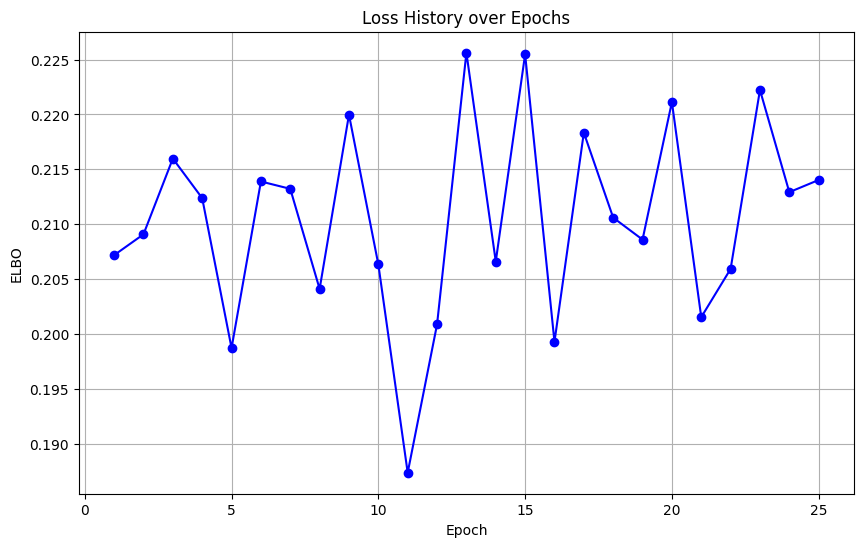

In [18]:
import matplotlib.pyplot as plt
# Plot loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_history, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('ELBO')
plt.title('Loss History over Epochs')
plt.grid(True)
plt.show()

In [19]:
# Define input shape
input_shape = (None, np.prod(data.shape[1:]))

# Build the model
model.build(input_shape)
print("Model built.")

dummy_input = tf.random.normal(shape=(1, np.prod(data.shape[1:])))  # Batch size of 1
model(dummy_input)  # This call will build the model

# Save the trained model
model_save_path = 'drive/MyDrive/trained_planar_vae'
model.save(model_save_path)
print(f"Model saved to {model_save_path}.")

Model built.
Model saved to drive/MyDrive/trained_planar_vae.
